# RNN-GRU SIMPLE CQR MODELS
This notebook contains the code for the Conformal Quantile Regression (CQR) calibration and evaluation of the two RNN-GRU models previously trained without covariates using the Darts library.

Both versions of the model are evaluated on their respective test sets, with the MinMax-scaled model also evaluated on a dedicated test set.

In [ ]:
# We install darts
!pip install u8darts[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Necessary imports to read the datasets
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts import concatenate, metrics
from darts.models import ConformalQRModel

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We start with minmax scaling

In [ ]:
# Load model
model = RNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/rnnGRU/simple/rnnGRU_model.pkl")

In [ ]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [ ]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts in zip(meter_ids_test, test_series_scaled):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        historical_forecasts=hfcs,
        last_points_only=False,
        retrain=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 253.38it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801501002_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.228377       22.433508 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 395.52it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801503008_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.254315       24.165025 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 405.41it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801901042_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.801021       12.463882 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 424.46it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.136814        1.667763 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 409.90it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.210315        3.531184 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 418.57it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902052_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  0.367299        4.157823 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 334.56it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902102_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.264097        3.538901 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 390.11it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903006_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.345255         3.55613 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 406.11it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.251958        0.705483 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 352.05it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903040_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.369657        1.005466 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 330.14it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903048_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.190892        4.432515 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 390.43it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903060_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.413226        5.185981 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 411.75it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903067_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.265934         0.92545 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 420.13it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903081_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  0.284354        2.459662 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 347.91it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.190495        7.863619 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 369.43it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904030_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.288316        3.699099 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 395.13it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801905054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.168088       17.119797 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 255.01it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801905091_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.379671        8.014853 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 419.07it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.319263        2.617954 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 377.64it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906010_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.297316         8.12861 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 417.63it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906041_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.226447        6.245404 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 424.79it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907003_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.087496        1.746425 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 392.68it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907011_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.298234        3.185144 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 372.98it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907013_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9       1.0  0.26331        2.343455 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 305.90it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907025_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.435106       12.091597 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.45it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.323277         5.69614 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 413.00it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907084_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  0.510921       13.140886 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 399.57it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.085285        5.528178 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 376.23it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907115_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.241744       17.959136 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 417.85it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.193598        3.906813 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 402.14it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908022_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.194761        2.909723 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 310.96it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908043_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.964286  0.15024        0.614481 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 403.21it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908046_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.339535        2.651769 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 405.83it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.265251       14.421724 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 399.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908061_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.248087        1.151125 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 368.17it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.209446           4.767 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 389.82it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908111_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.361087        9.254658 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 375.88it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801909015_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.225353        6.116074 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 326.01it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801909017_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.240655        9.070275 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 348.84it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910053_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.398905        6.849191 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 392.85it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.589191         6.24542 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 276.34it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910080_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.928571  0.36769         1.70976 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 402.93it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910092_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.616567        2.330622 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 375.19it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910119_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.259551        1.134237 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910235_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.803571  0.28697        0.792036 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 219.85it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.390509         7.81018 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 385.23it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101041_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.156284        3.361658 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 417.33it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.625  0.455496        6.390603 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 410.73it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.181756        2.293756 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 408.36it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102017_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.418673        6.167054 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 328.20it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.718785       22.526723 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 412.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102045_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.522218       12.940551 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 396.96it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102048_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.146596         3.55056 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 373.79it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810104040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.365475        1.640981 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 412.24it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.137828        0.840752 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 382.74it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105026_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  0.104387        2.962511 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 411.47it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105032_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.221478        4.894662 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 296.81it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810106012_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.178813        1.578921 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 395.12it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810106013_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.353839        2.307032 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 272.10it/s]

Results for meter 0810106023_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.362474        2.167593 



In [ ]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

Mean Coverage: 0.8949
Mean Width: 0.3027
Mean Width rescaled: 6.0161


In [ ]:
import matplotlib.pyplot as plt
from darts import concatenate  # Darts utility to merge TimeSeries

for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Let's continue with the standard scaling

In [ ]:
# Load model
model = RNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/rnnGRU/simple/rnnGRU_model_standard.pkl")

In [ ]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test_standard.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [ ]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts in zip(meter_ids_test, test_series_scaled):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        historical_forecasts=hfcs,
        last_points_only=False,
        retrain=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 277.13it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801501002_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  1.887048       22.280872 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 470.17it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801503008_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.464365       23.817617 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 465.09it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801901042_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  5.678559       12.034334 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 260.01it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.043035        2.051345 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 463.72it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.502388        3.576897 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.22it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902052_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  2.470674        4.268387 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 402.91it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902102_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.400409        2.993901 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 456.85it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903006_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.892094        3.002275 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 330.95it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.793028        0.816341 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 469.58it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903040_Barcelona:
    Interval  Coverage  Width  Width rescaled
0       0.9  0.857143  2.385         1.04406 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 475.03it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903048_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  2.284454        4.165692 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 445.01it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903060_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  2.293837        4.555308 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 405.02it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903067_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.489525        0.951167 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 345.02it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903081_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  1.574439         2.15003 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 451.23it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.767857  1.619732        7.965063 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 462.78it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904030_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.905092        3.905202 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 469.04it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801905054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.923443       16.691852 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 468.68it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801905091_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.710509        6.876386 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 326.60it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  1.900199        2.824498 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.58it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906010_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.106039        8.067657 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 415.44it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906041_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.910714  1.72025         7.40296 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.19it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907003_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.831517        1.767306 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 476.65it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907011_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.694165         2.78369 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 451.21it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907013_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.491972        2.200096 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 328.59it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907025_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  2.316053        9.716448 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 467.96it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  2.319557         6.00213 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 359.40it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907084_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  3.182632       10.889954 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 438.06it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.805211        6.031667 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 447.11it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801907115_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  1.408153       20.874522 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 271.25it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  1.164635        2.732455 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.74it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908022_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  1.465317        2.514234 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908043_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  1.369953        0.617463 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 434.17it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908046_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.842083        2.182577 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 460.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.420049       13.569721 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 295.38it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908061_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.363974        1.040358 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.80it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.351419        5.083312 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 415.04it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801908111_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.767857  2.430621        9.206013 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 294.99it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801909015_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.531642        7.048537 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 459.62it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801909017_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  1.288184        7.399883 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910053_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  2.668871        7.848291 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.60it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.879795        4.004027 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 406.03it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910080_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.767857  2.545687        1.659387 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 363.76it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910092_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  2.940516        1.785072 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 393.97it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910119_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.924523        0.932622 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 469.94it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910235_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.664896        0.842812 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 338.68it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.653835        6.505214 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 434.45it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101041_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.383368        3.003355 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 476.56it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9      0.75  3.23813        7.287363 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 449.01it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.551899          2.1518 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.40it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102017_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  2.059623        5.847389 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 296.88it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.607143  3.334054       19.721101 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 460.86it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102045_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  2.178227         9.83471 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 393.19it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102048_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  2.352282        3.872254 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 357.54it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810104040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.319134        1.397599 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 455.69it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  0.785515        0.495154 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 407.38it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105026_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.928571  1.46716        3.544346 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 455.33it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810105032_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  1.816197        4.913744 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.09it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810106012_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.821429  1.09271        1.386024 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 325.06it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810106013_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  2.185007        2.488844 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 466.96it/s]

Results for meter 0810106023_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.192238        2.083121 



In [ ]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

Mean Coverage: 0.8824
Mean Width: 1.8759
Mean Width rescaled: 5.7451


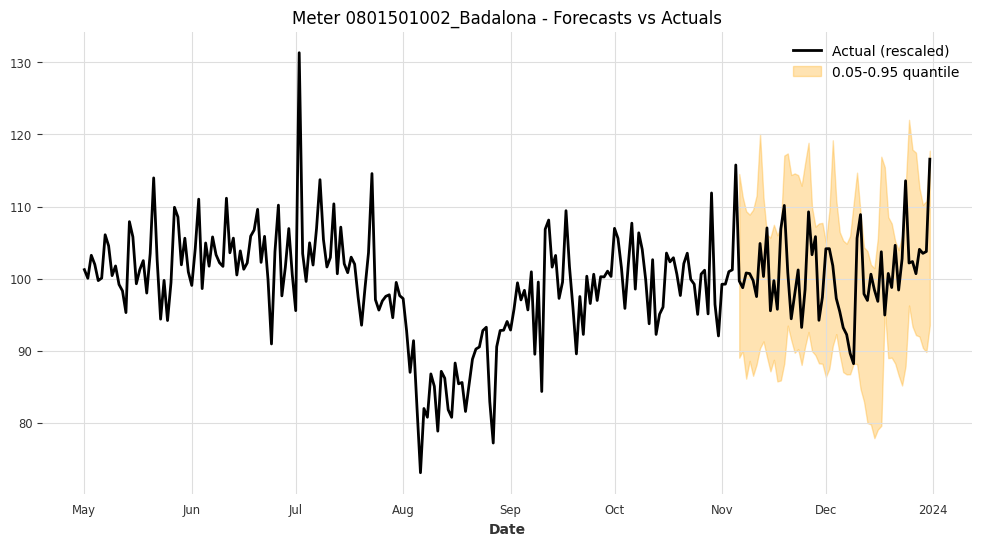

Meter 0801501002_Badalona - Coverage: 0.9464, Width: 22.2809



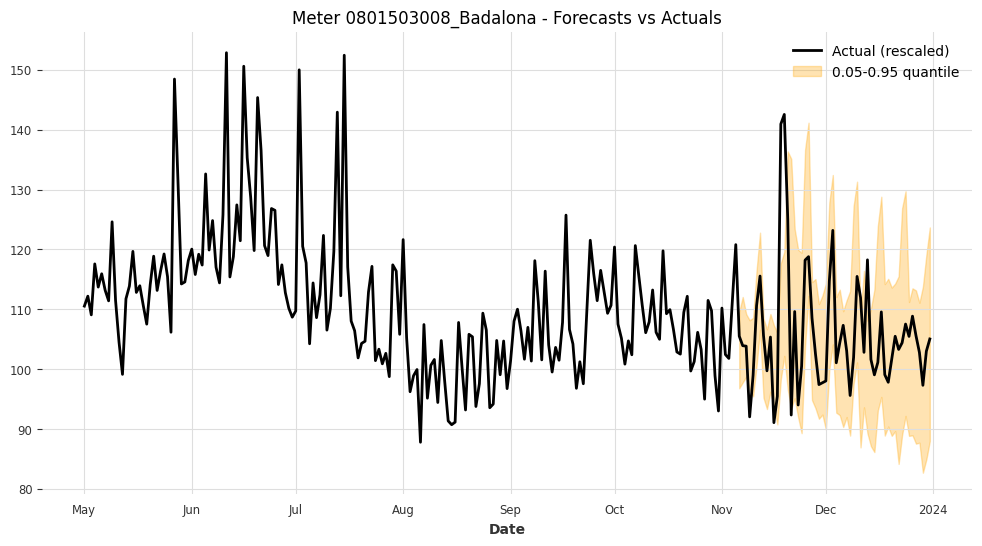

Meter 0801503008_Badalona - Coverage: 0.8750, Width: 23.8176



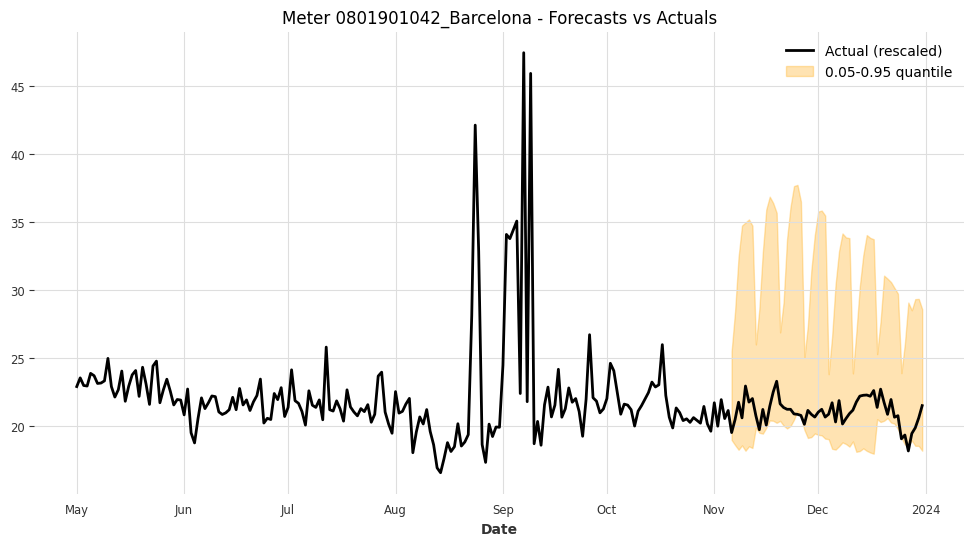

Meter 0801901042_Barcelona - Coverage: 0.9464, Width: 12.0343



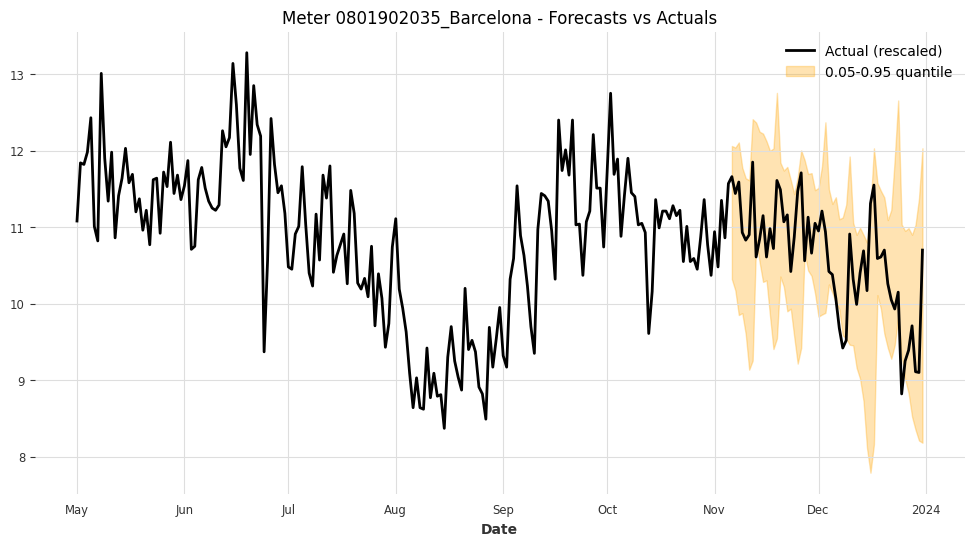

Meter 0801902035_Barcelona - Coverage: 0.8750, Width: 2.0513



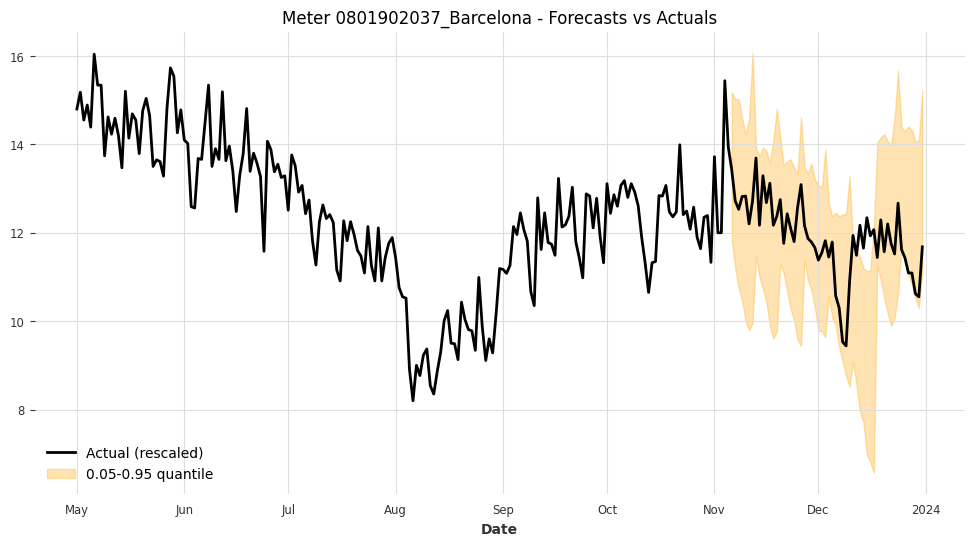

Meter 0801902037_Barcelona - Coverage: 0.8929, Width: 3.5769



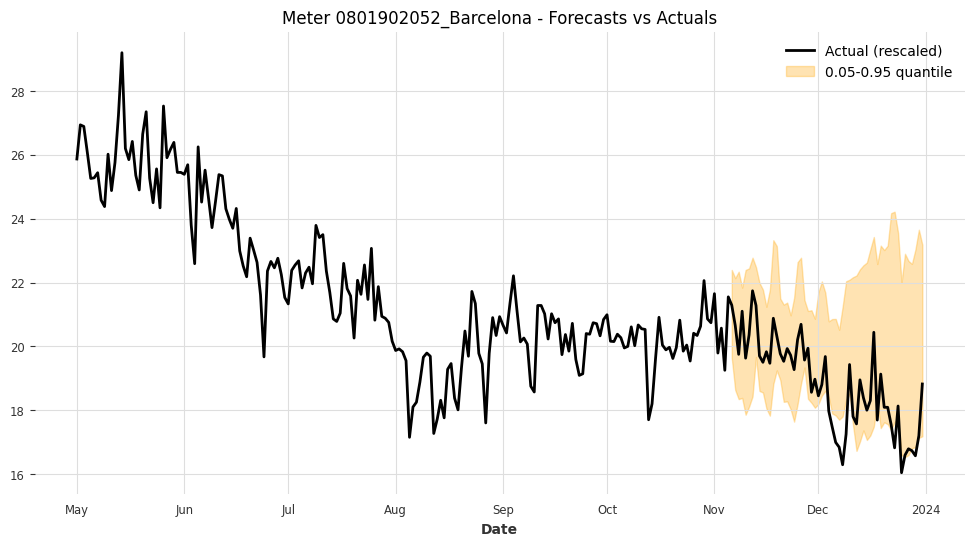

Meter 0801902052_Barcelona - Coverage: 0.8036, Width: 4.2684



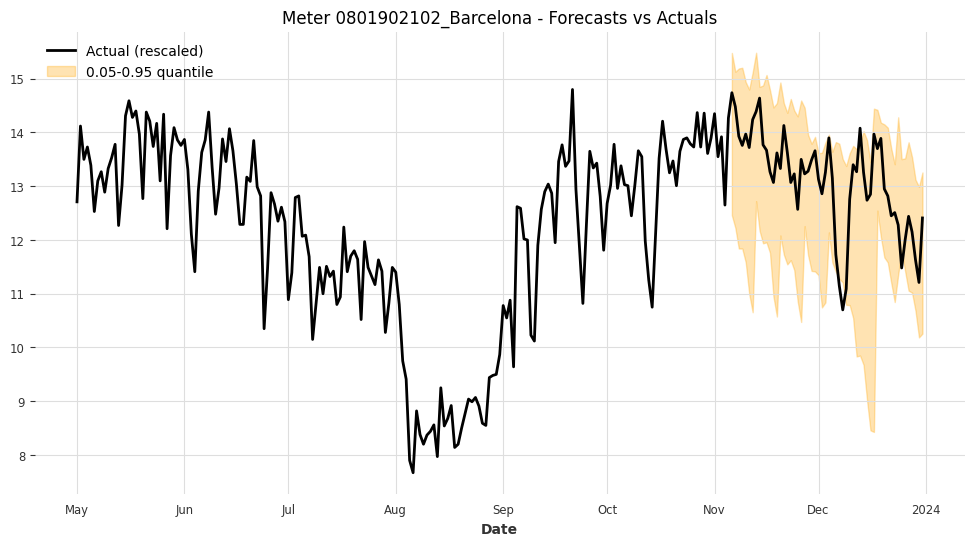

Meter 0801902102_Barcelona - Coverage: 0.9286, Width: 2.9939



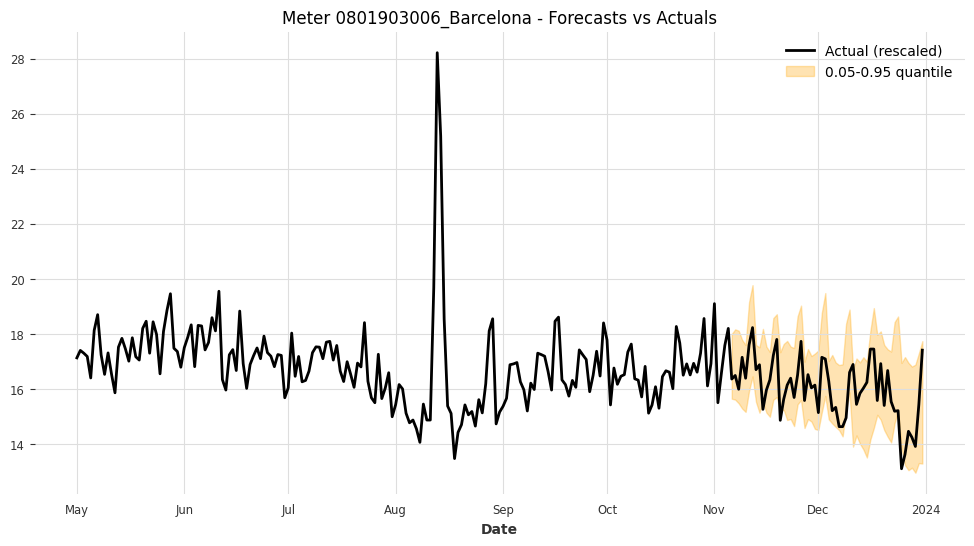

Meter 0801903006_Barcelona - Coverage: 0.9107, Width: 3.0023



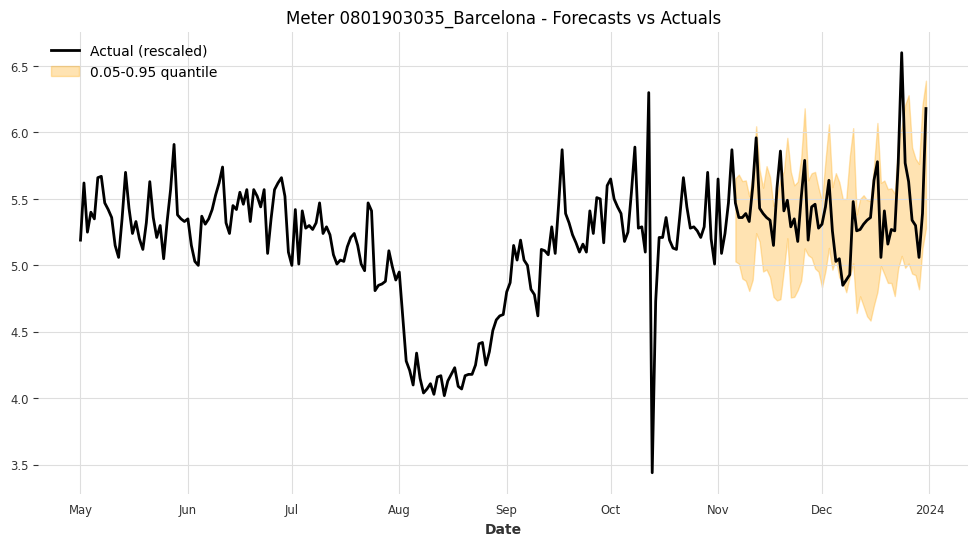

Meter 0801903035_Barcelona - Coverage: 0.9107, Width: 0.8163



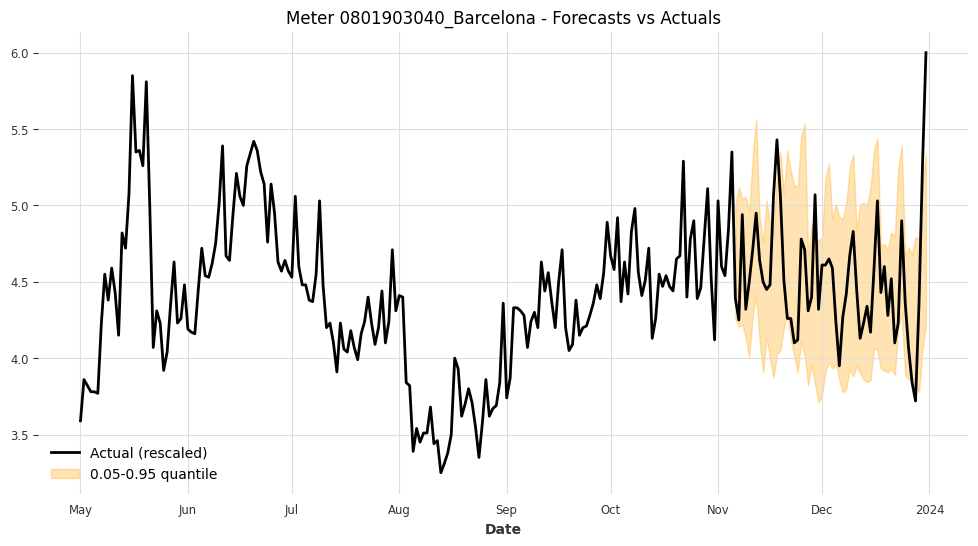

Meter 0801903040_Barcelona - Coverage: 0.8571, Width: 1.0441



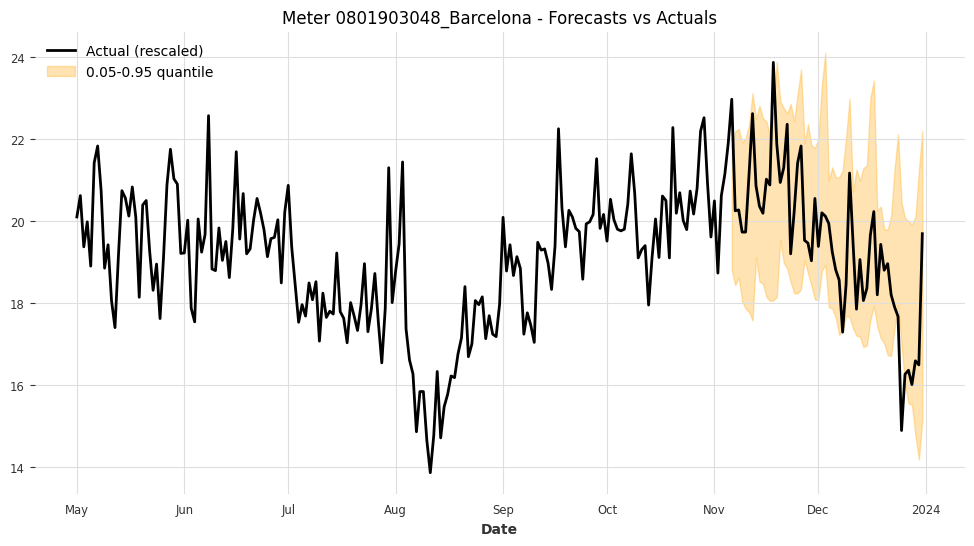

Meter 0801903048_Barcelona - Coverage: 0.9107, Width: 4.1657



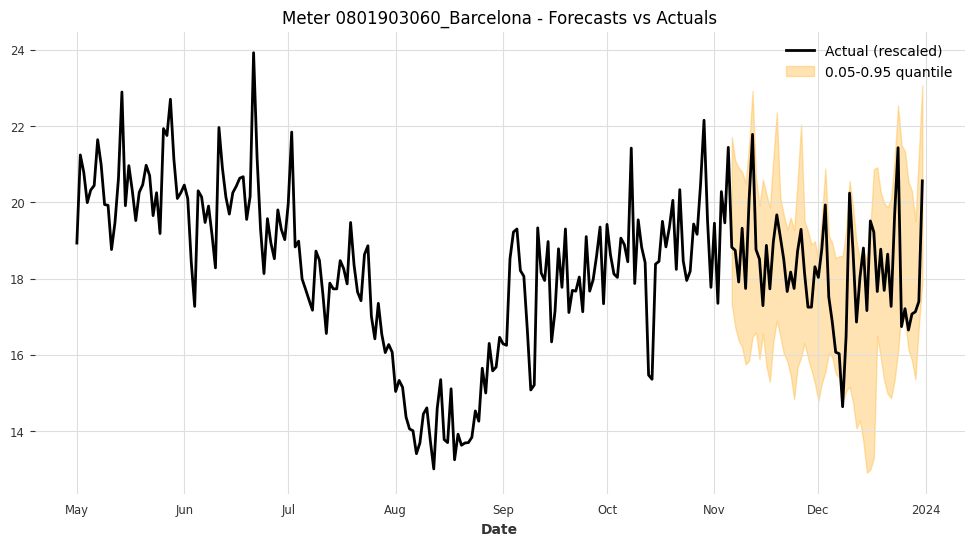

Meter 0801903060_Barcelona - Coverage: 0.9286, Width: 4.5553



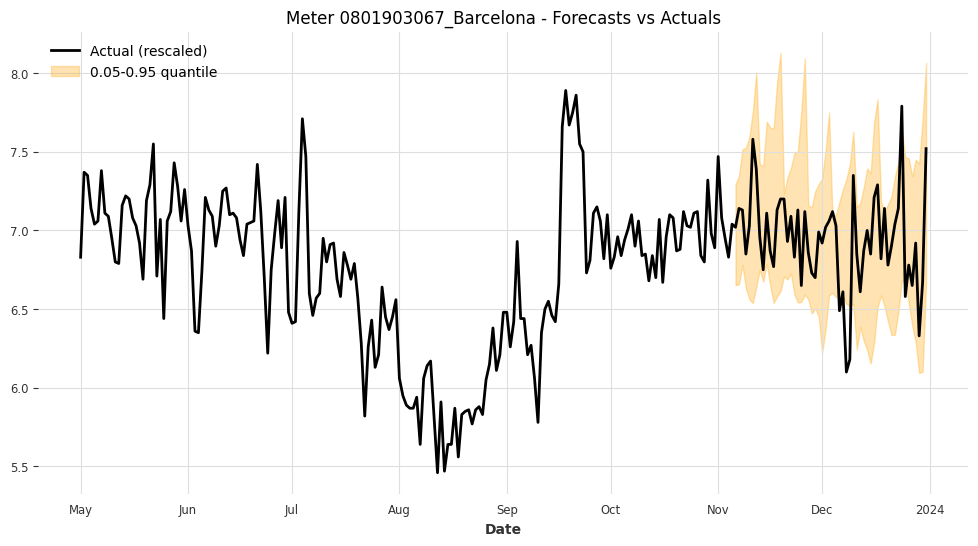

Meter 0801903067_Barcelona - Coverage: 0.8750, Width: 0.9512



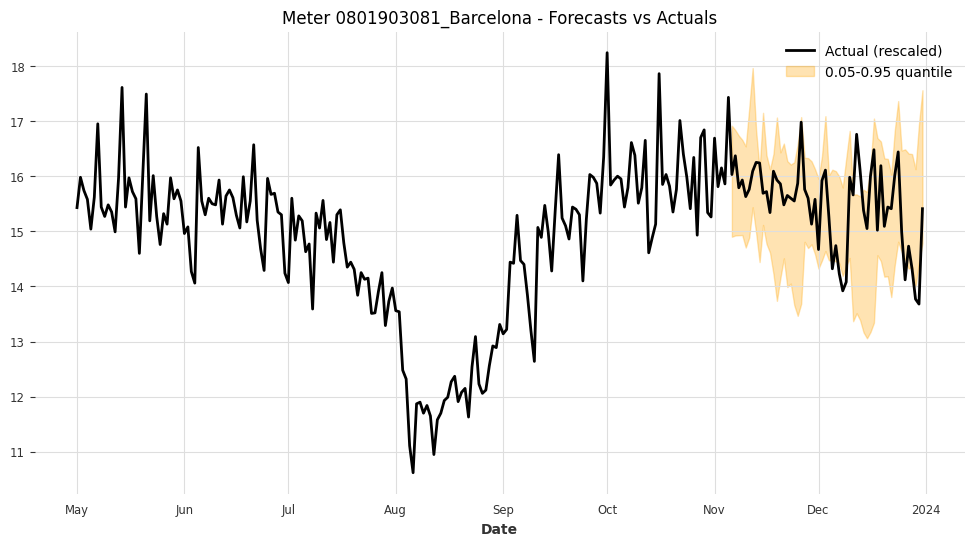

Meter 0801903081_Barcelona - Coverage: 0.8036, Width: 2.1500



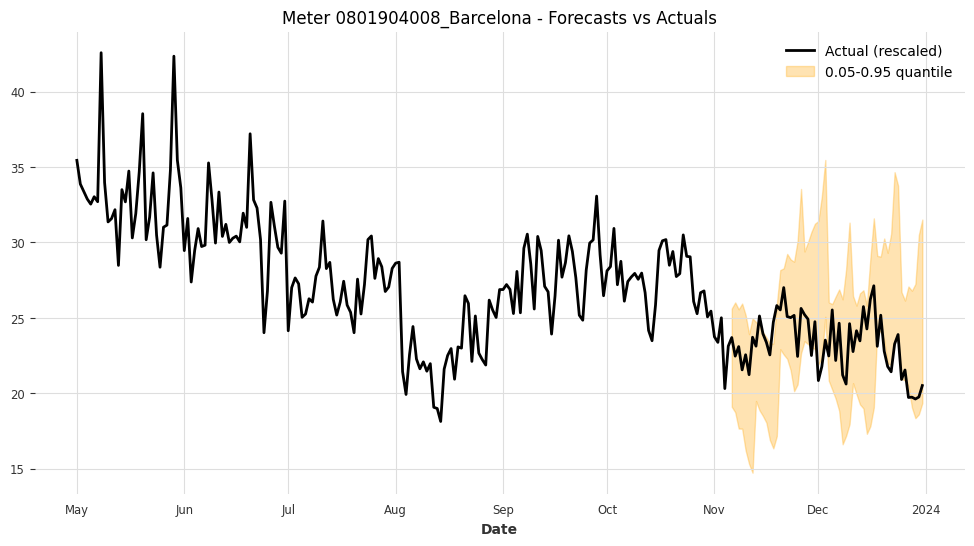

Meter 0801904008_Barcelona - Coverage: 0.7679, Width: 7.9651



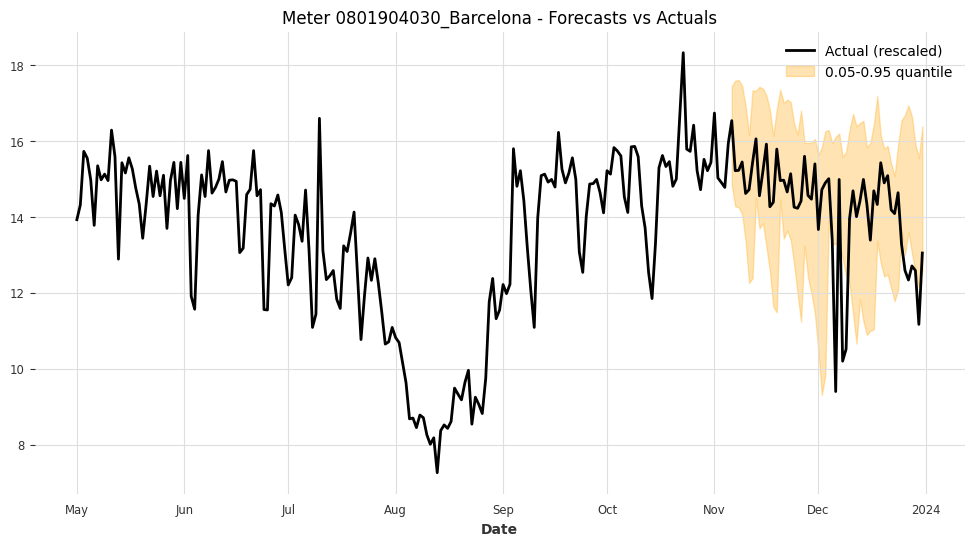

Meter 0801904030_Barcelona - Coverage: 0.8571, Width: 3.9052



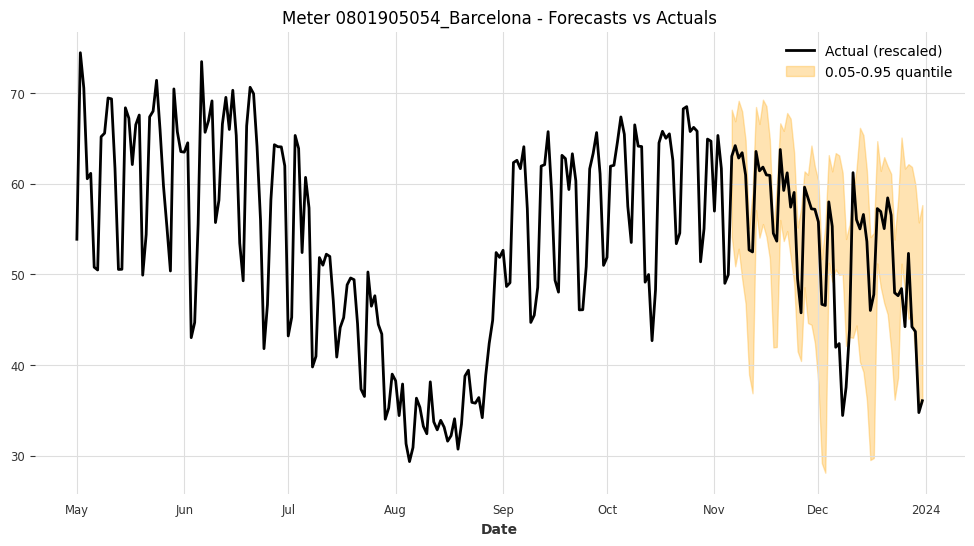

Meter 0801905054_Barcelona - Coverage: 0.8393, Width: 16.6919



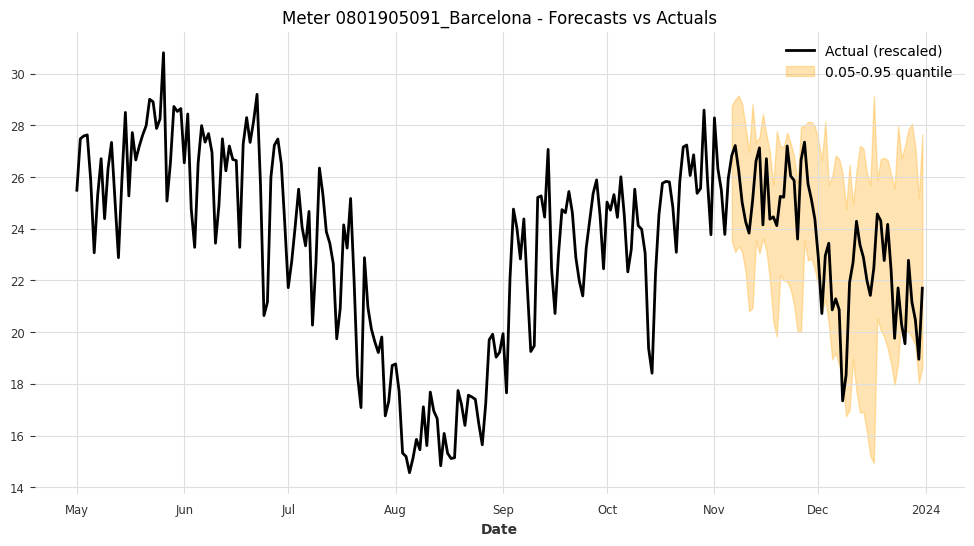

Meter 0801905091_Barcelona - Coverage: 0.9286, Width: 6.8764



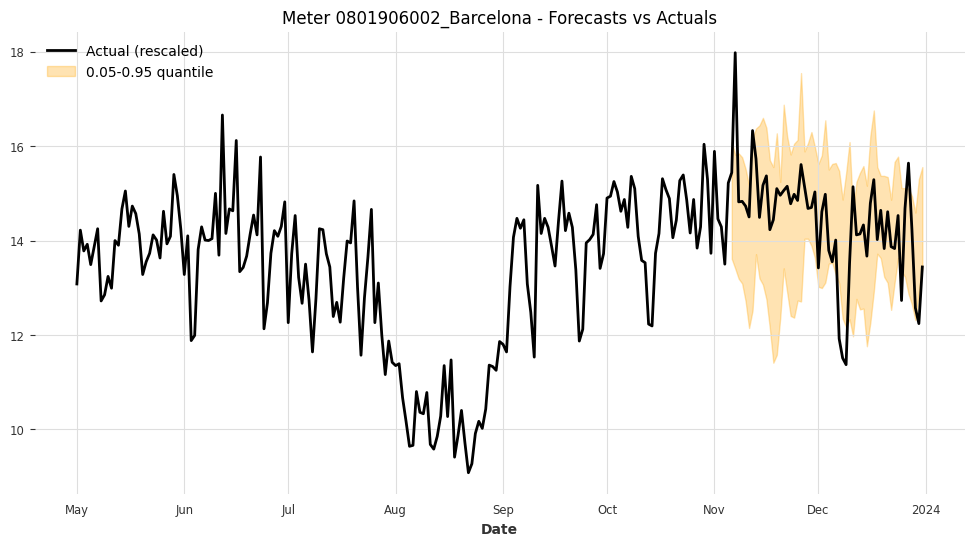

Meter 0801906002_Barcelona - Coverage: 0.8393, Width: 2.8245



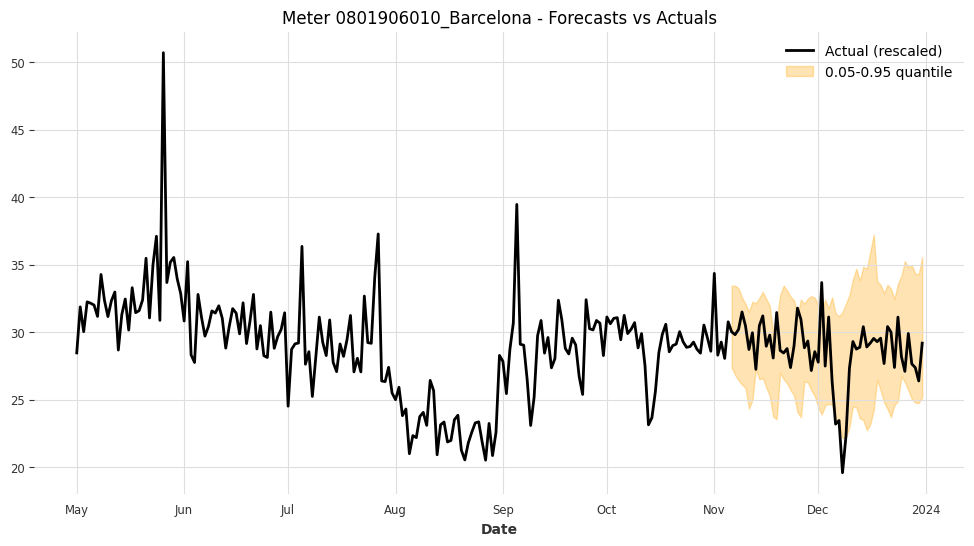

Meter 0801906010_Barcelona - Coverage: 0.8929, Width: 8.0677



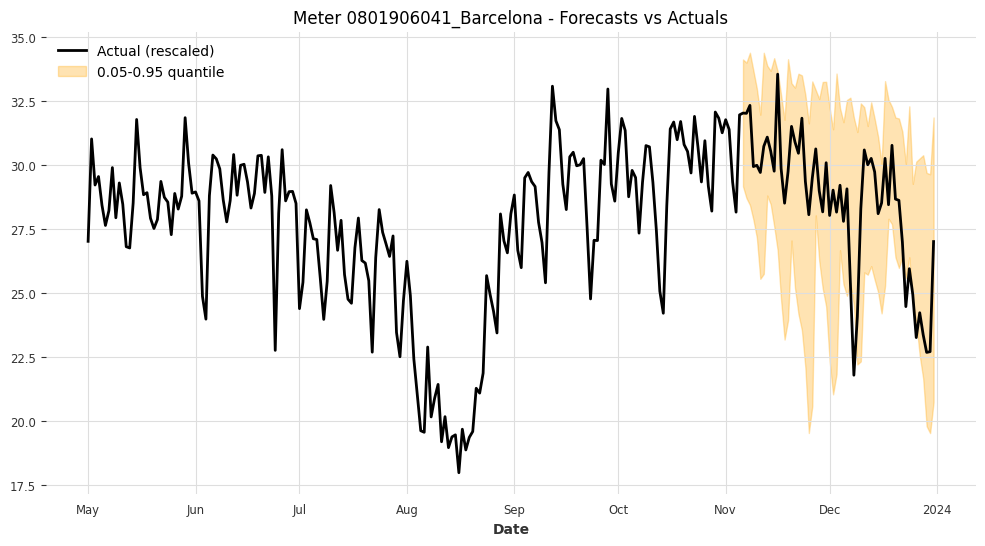

Meter 0801906041_Barcelona - Coverage: 0.9107, Width: 7.4030



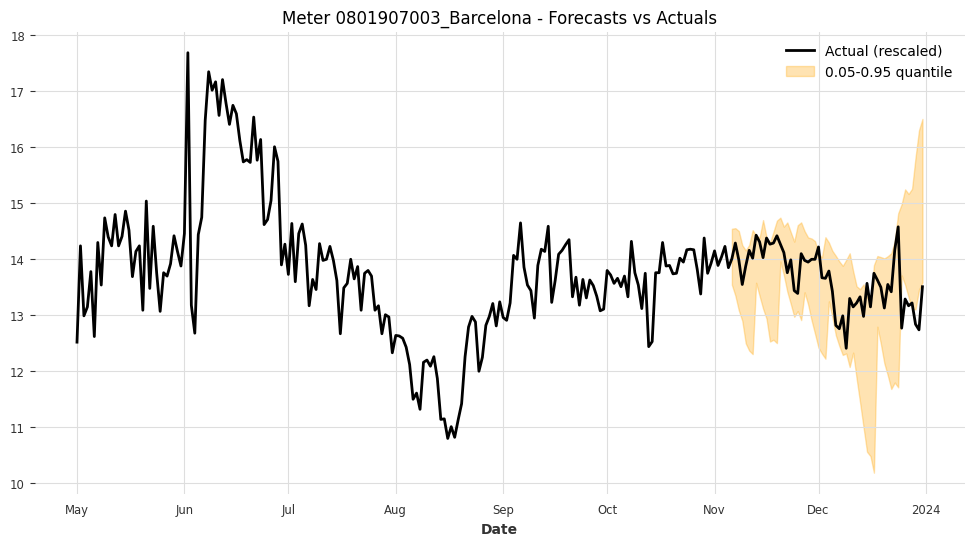

Meter 0801907003_Barcelona - Coverage: 0.8393, Width: 1.7673



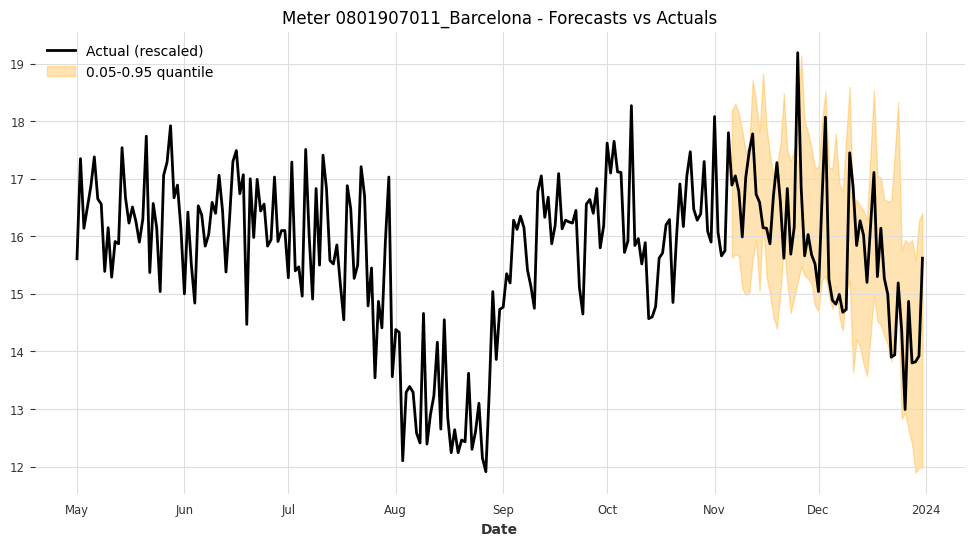

Meter 0801907011_Barcelona - Coverage: 0.8571, Width: 2.7837



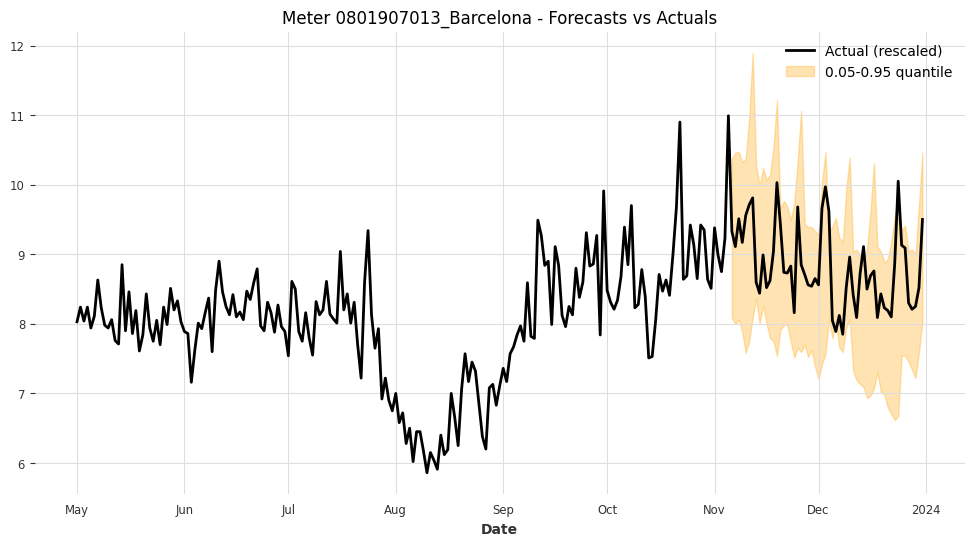

Meter 0801907013_Barcelona - Coverage: 0.9286, Width: 2.2001



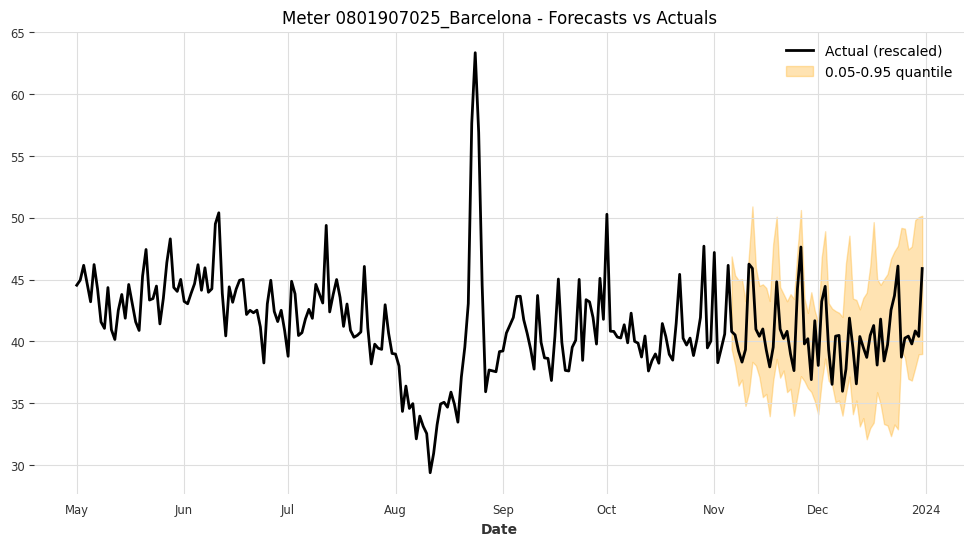

Meter 0801907025_Barcelona - Coverage: 0.9821, Width: 9.7164



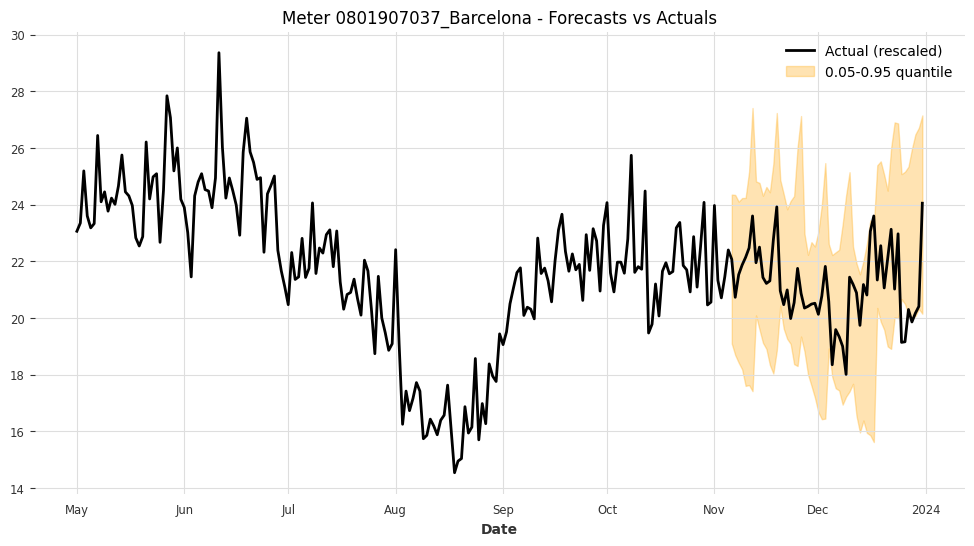

Meter 0801907037_Barcelona - Coverage: 0.9286, Width: 6.0021



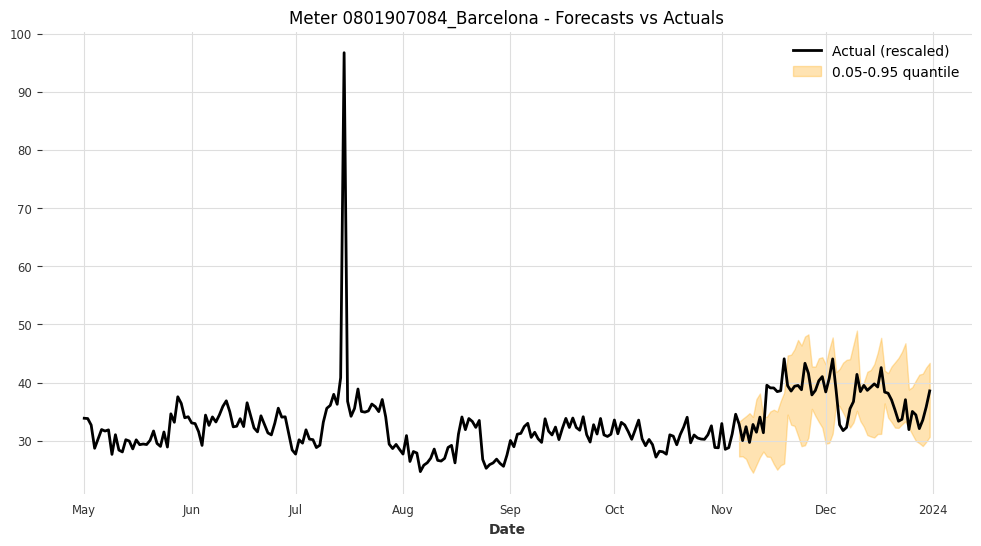

Meter 0801907084_Barcelona - Coverage: 0.8214, Width: 10.8900



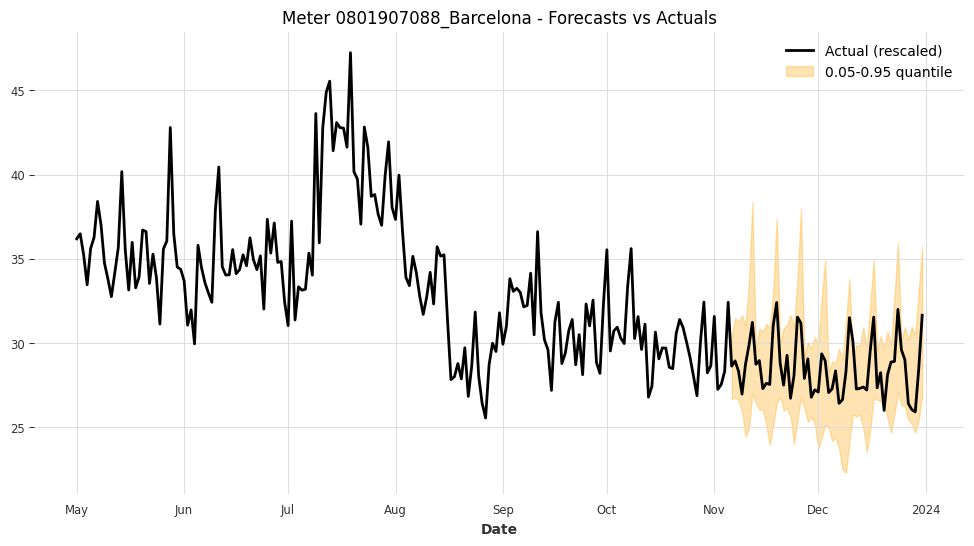

Meter 0801907088_Barcelona - Coverage: 0.9643, Width: 6.0317



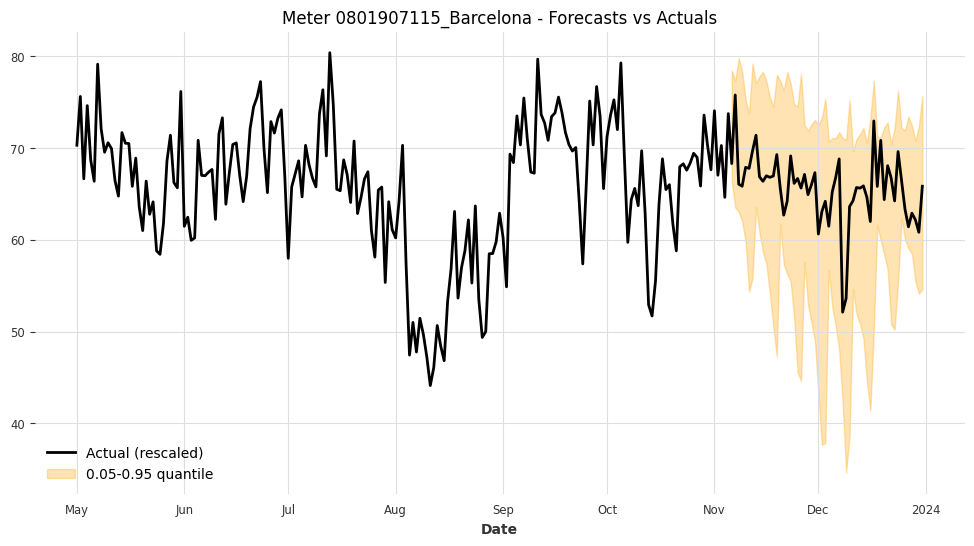

Meter 0801907115_Barcelona - Coverage: 1.0000, Width: 20.8745



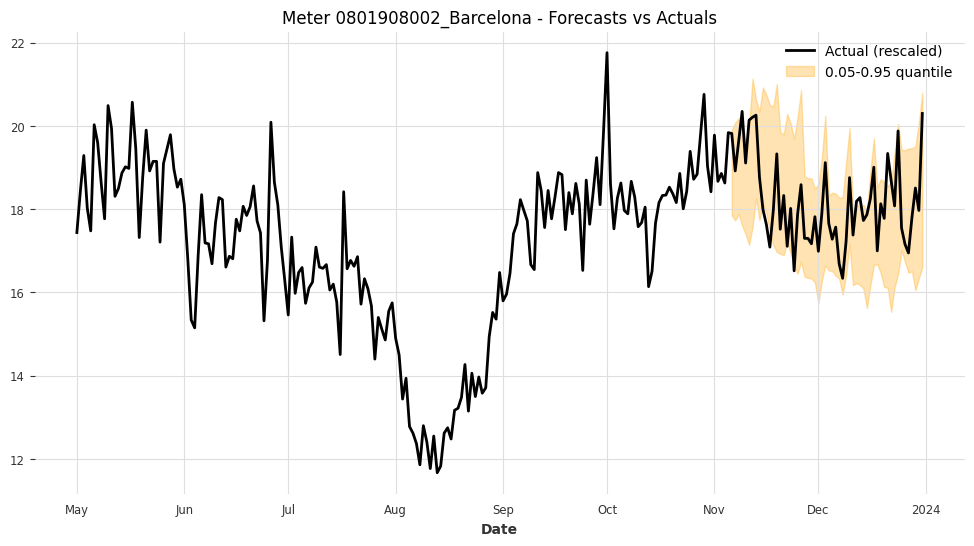

Meter 0801908002_Barcelona - Coverage: 0.8036, Width: 2.7325



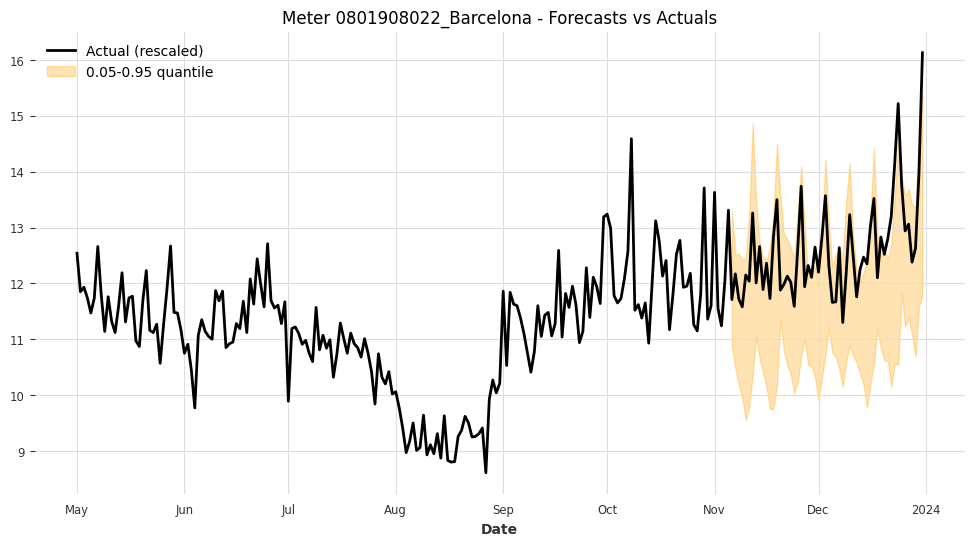

Meter 0801908022_Barcelona - Coverage: 0.7857, Width: 2.5142



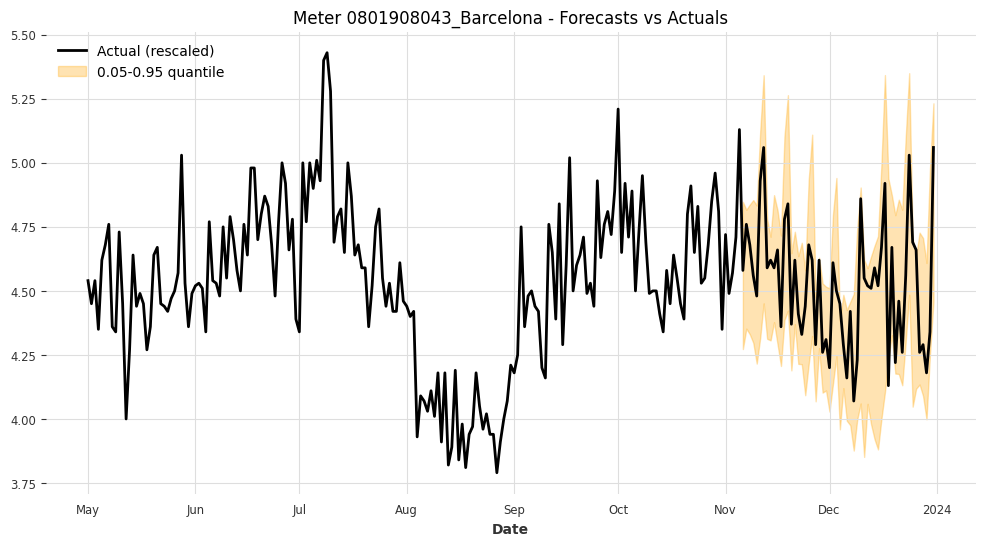

Meter 0801908043_Barcelona - Coverage: 0.9464, Width: 0.6175



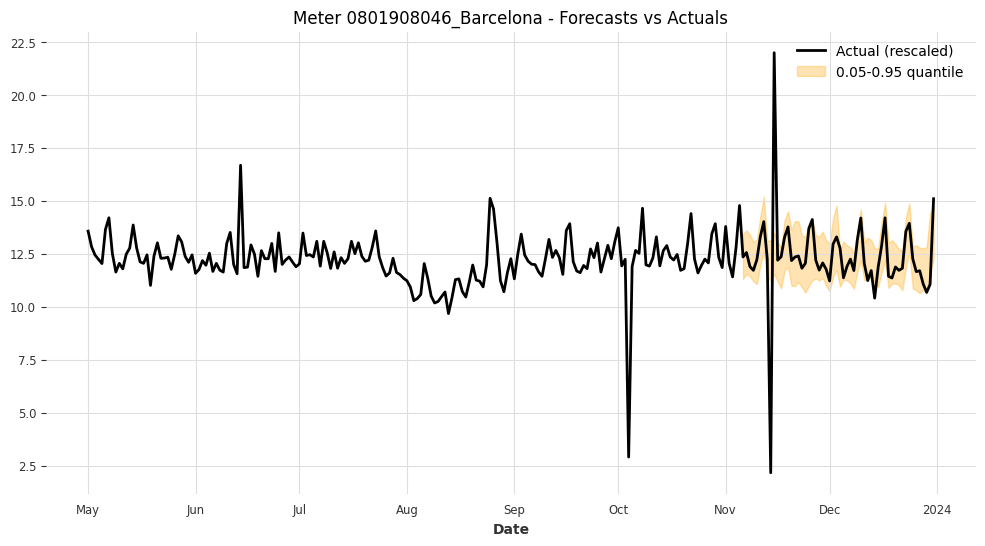

Meter 0801908046_Barcelona - Coverage: 0.8571, Width: 2.1826



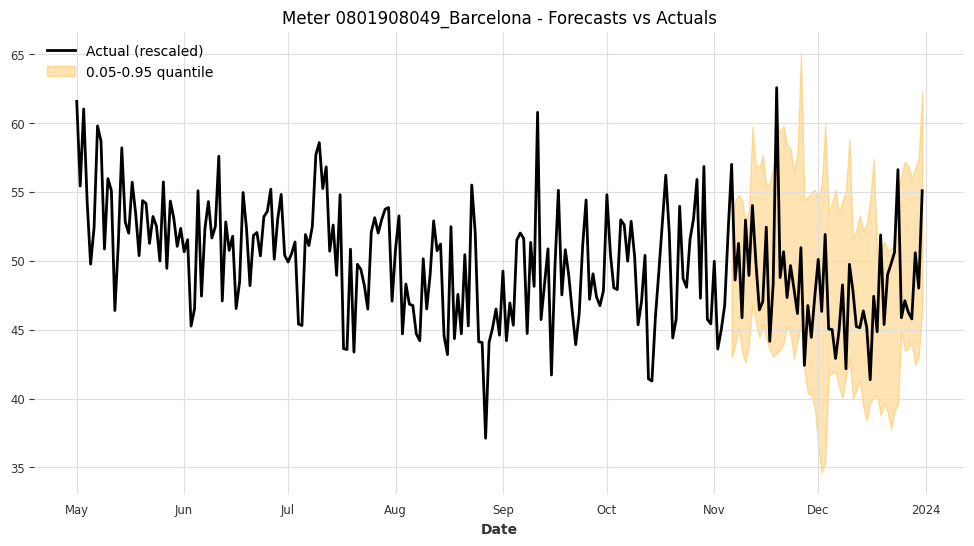

Meter 0801908049_Barcelona - Coverage: 0.9107, Width: 13.5697



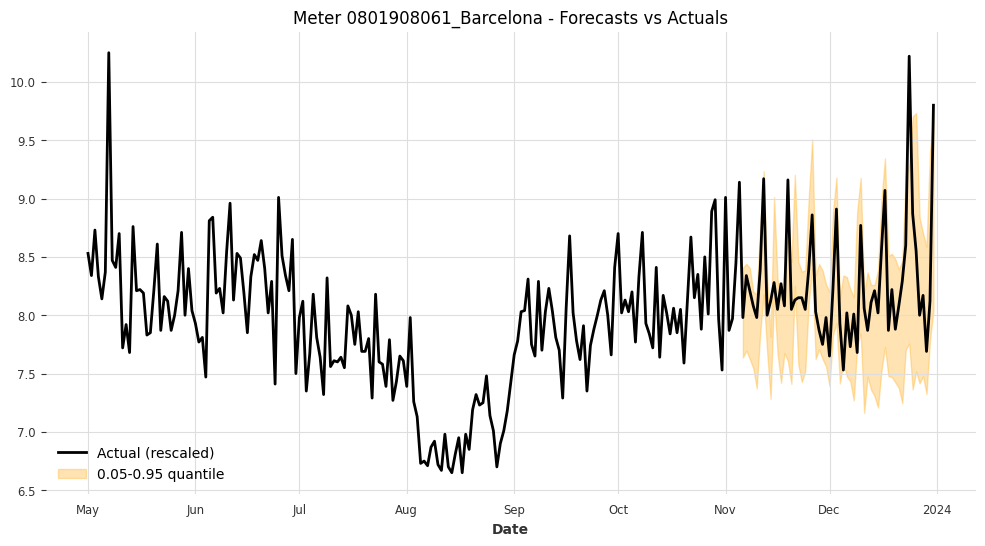

Meter 0801908061_Barcelona - Coverage: 0.8571, Width: 1.0404



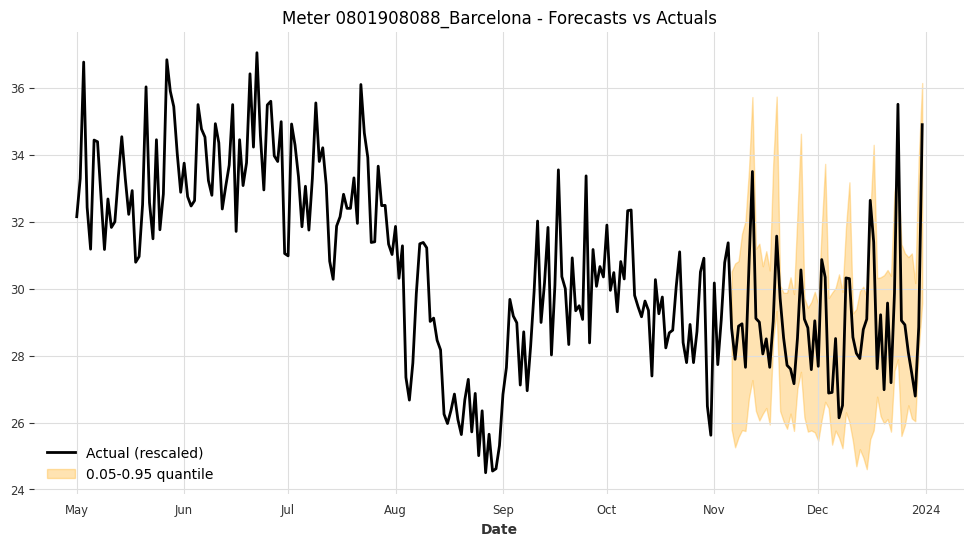

Meter 0801908088_Barcelona - Coverage: 0.9643, Width: 5.0833



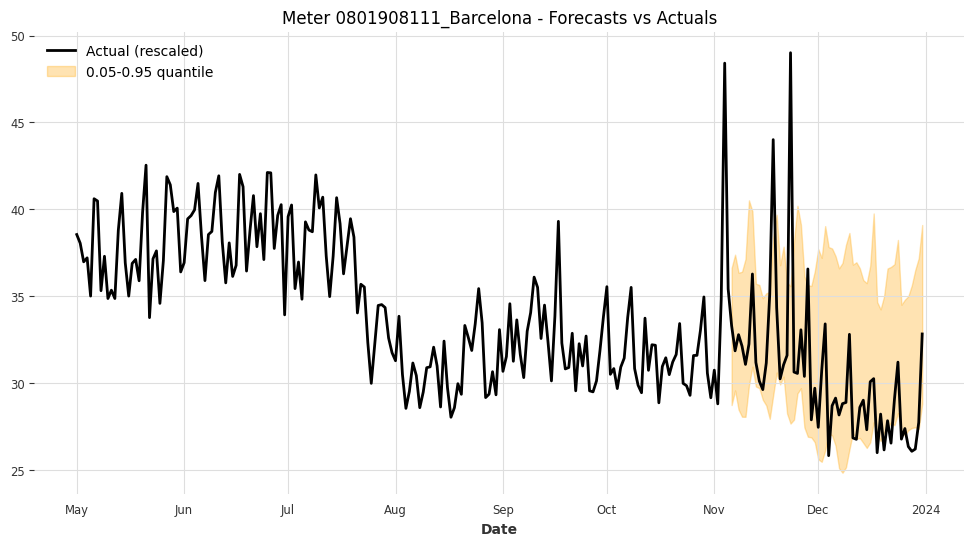

Meter 0801908111_Barcelona - Coverage: 0.7679, Width: 9.2060



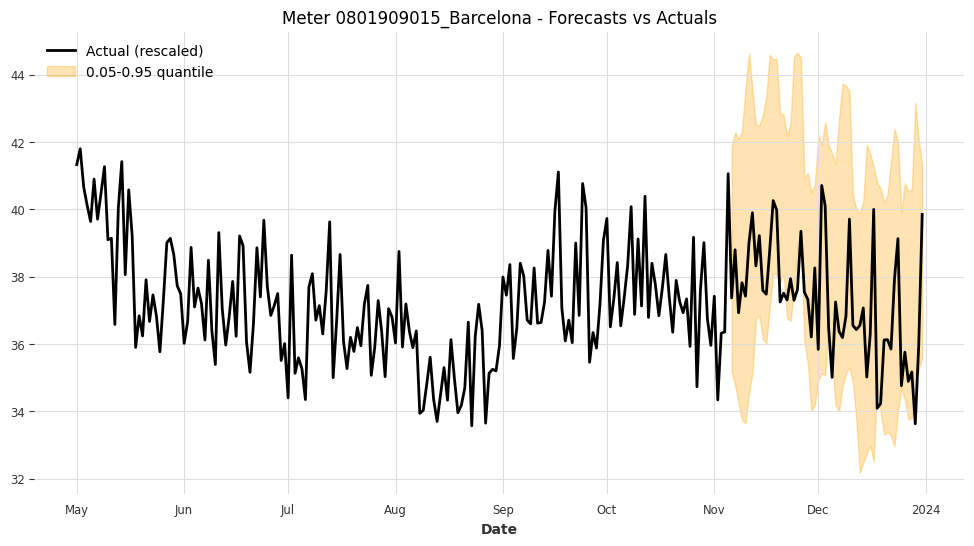

Meter 0801909015_Barcelona - Coverage: 0.8571, Width: 7.0485



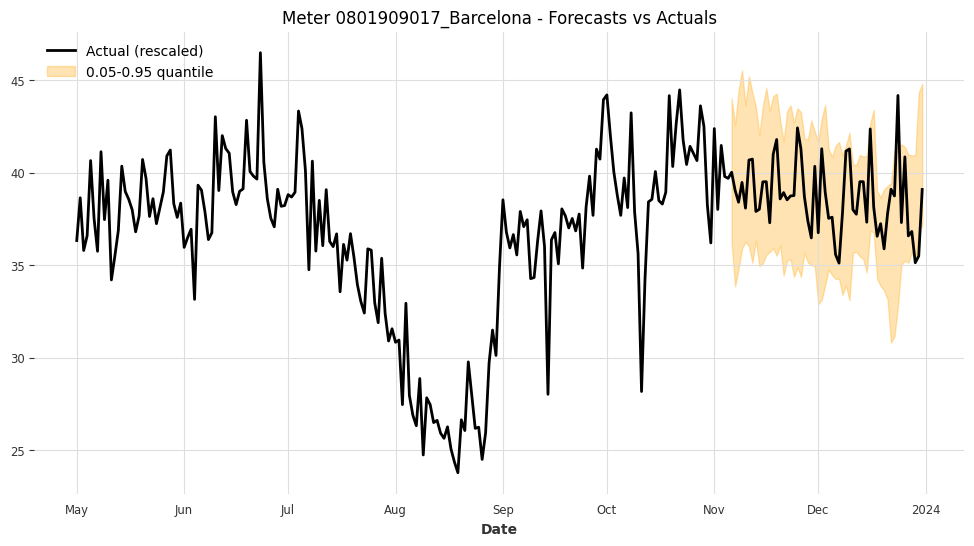

Meter 0801909017_Barcelona - Coverage: 0.9464, Width: 7.3999



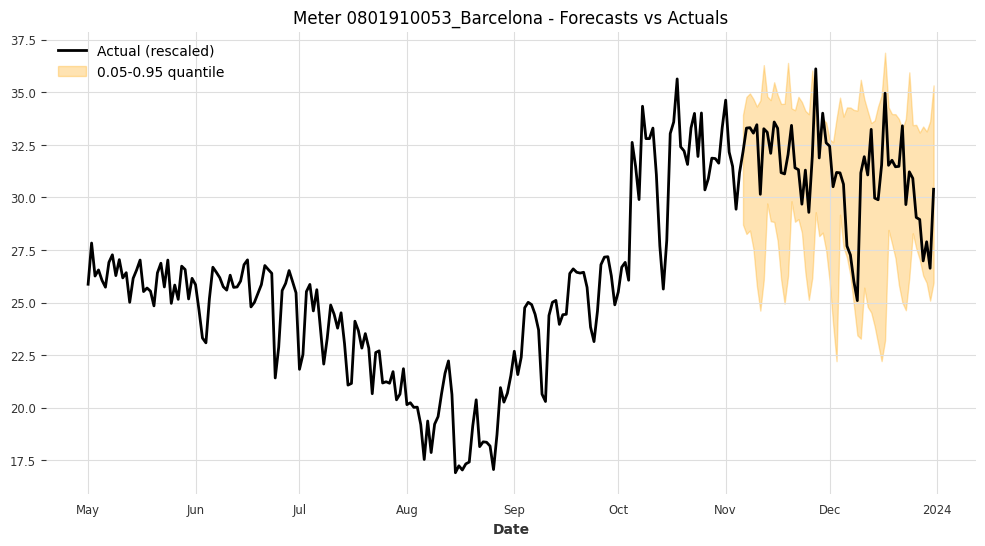

Meter 0801910053_Barcelona - Coverage: 0.9464, Width: 7.8483



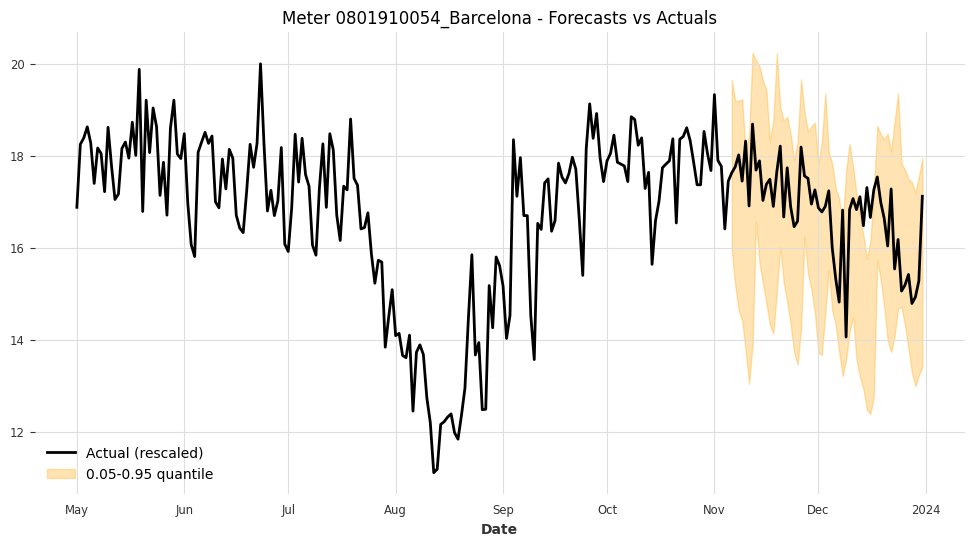

Meter 0801910054_Barcelona - Coverage: 0.8750, Width: 4.0040



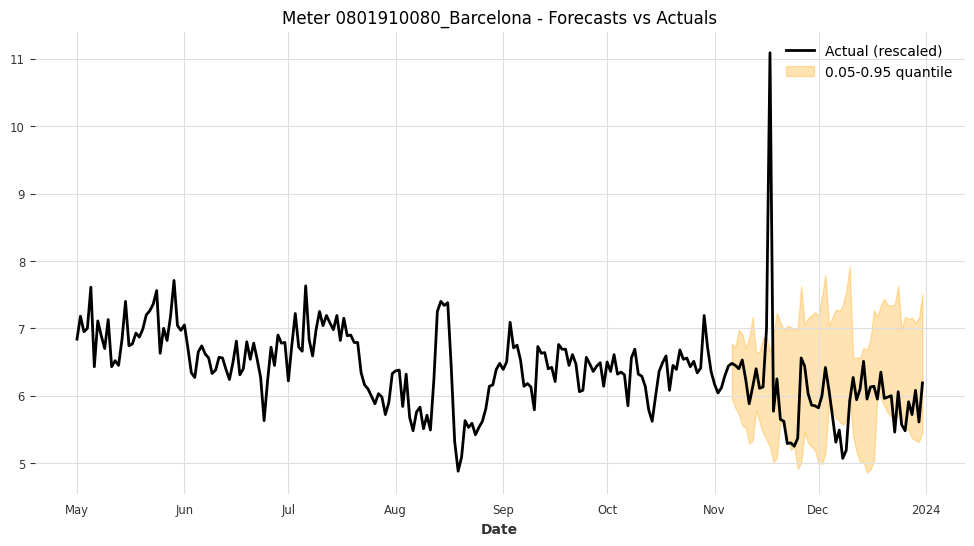

Meter 0801910080_Barcelona - Coverage: 0.7679, Width: 1.6594



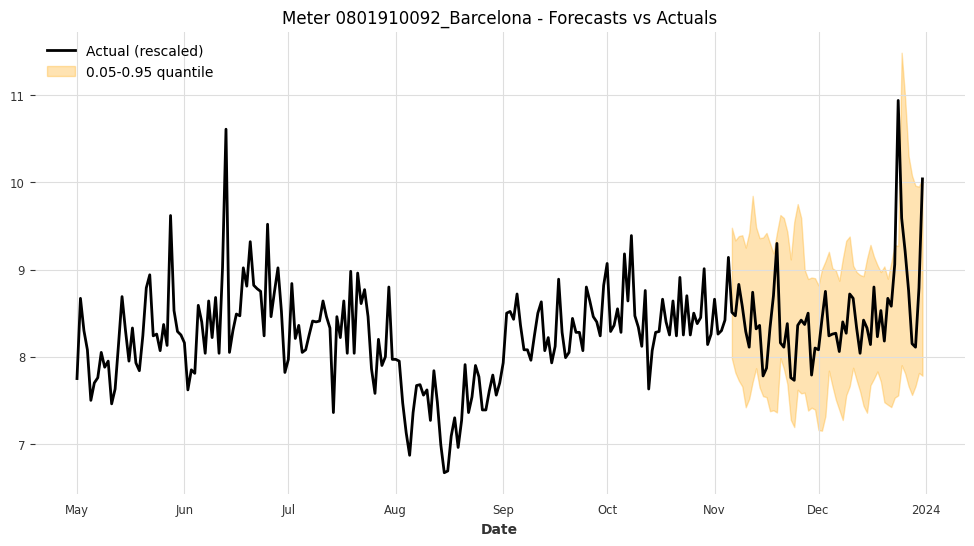

Meter 0801910092_Barcelona - Coverage: 0.9821, Width: 1.7851



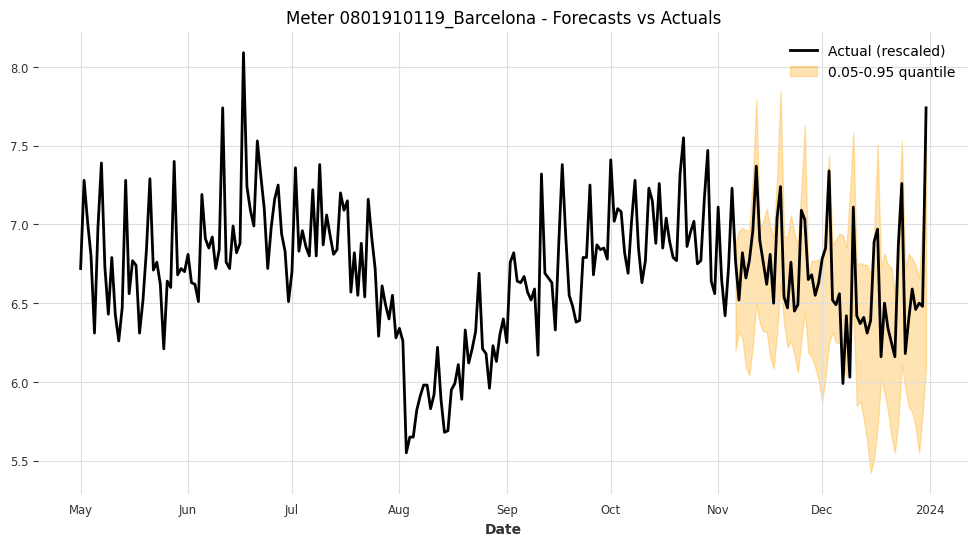

Meter 0801910119_Barcelona - Coverage: 0.9286, Width: 0.9326



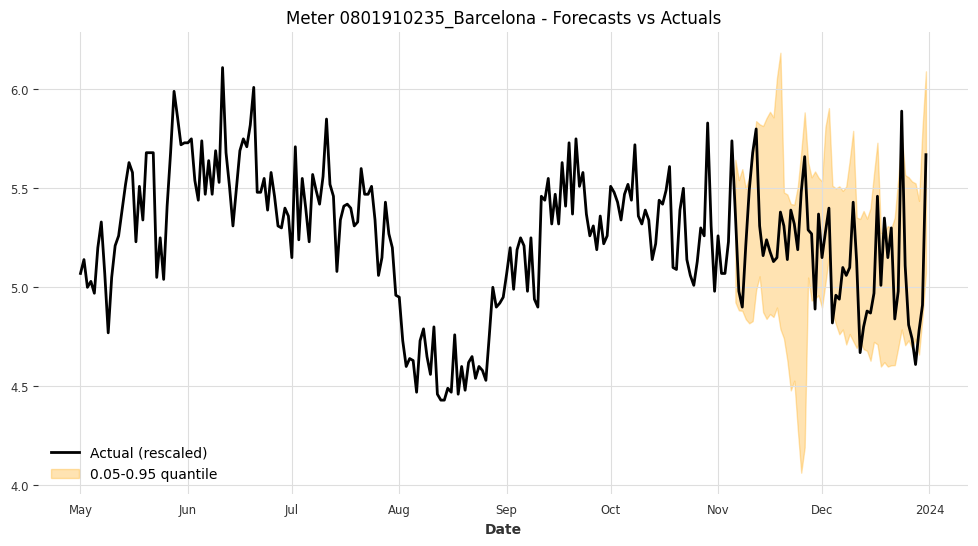

Meter 0801910235_Barcelona - Coverage: 0.8571, Width: 0.8428



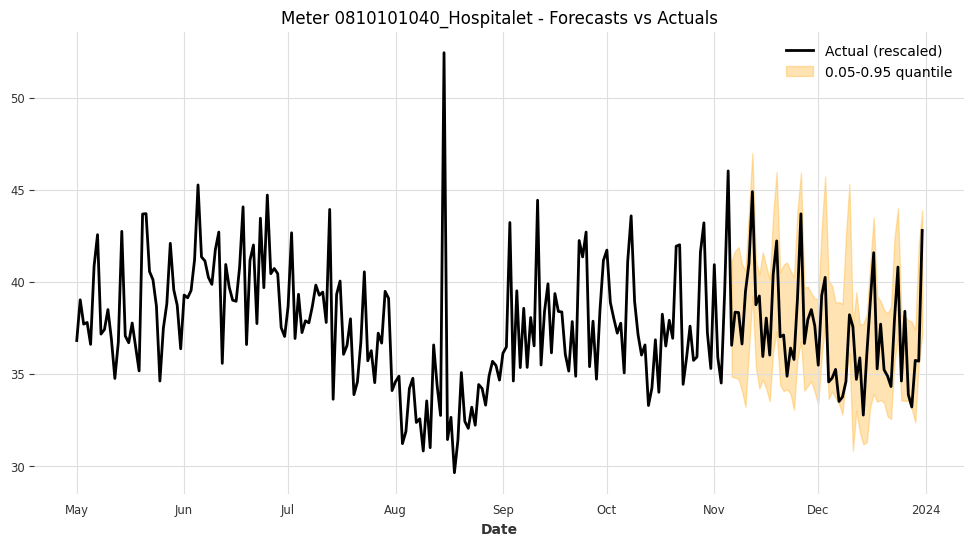

Meter 0810101040_Hospitalet - Coverage: 0.9643, Width: 6.5052



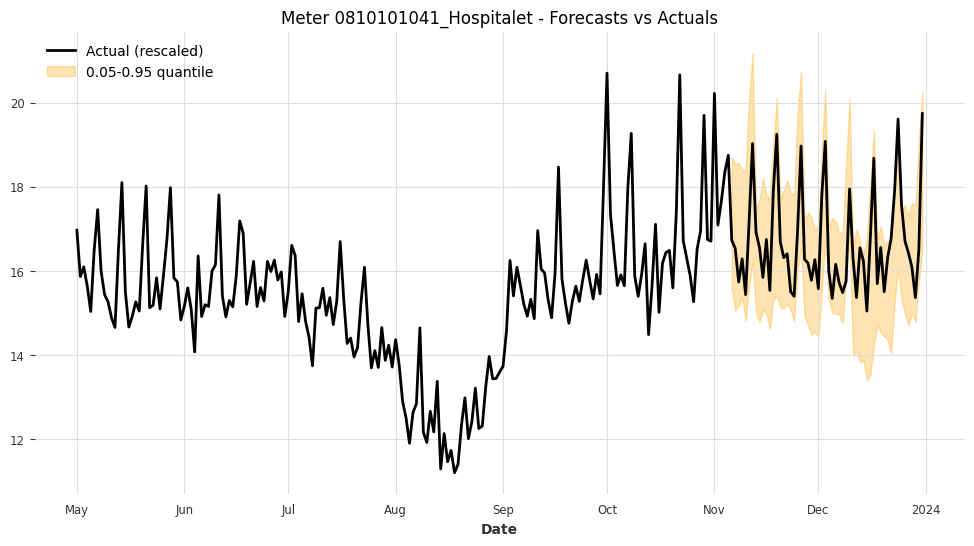

Meter 0810101041_Hospitalet - Coverage: 0.9286, Width: 3.0034



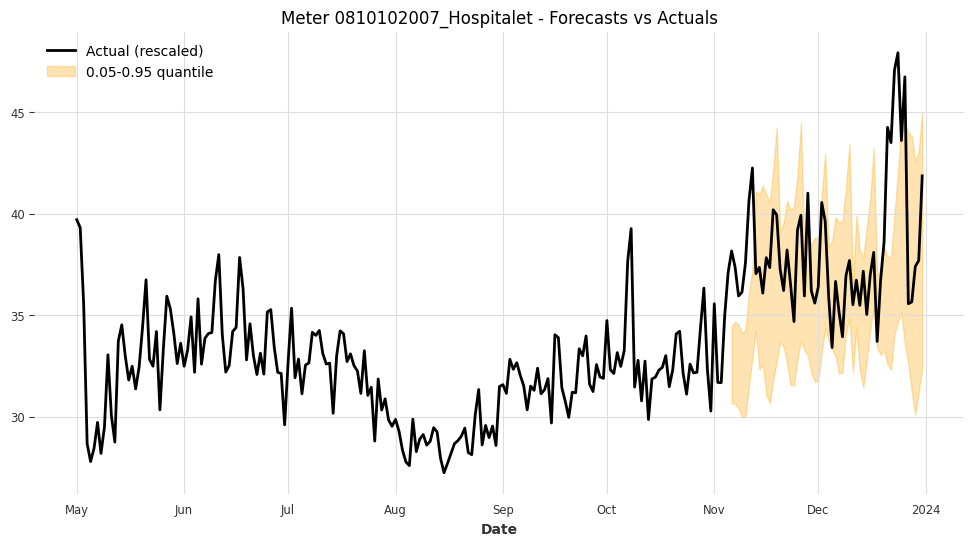

Meter 0810102007_Hospitalet - Coverage: 0.7500, Width: 7.2874



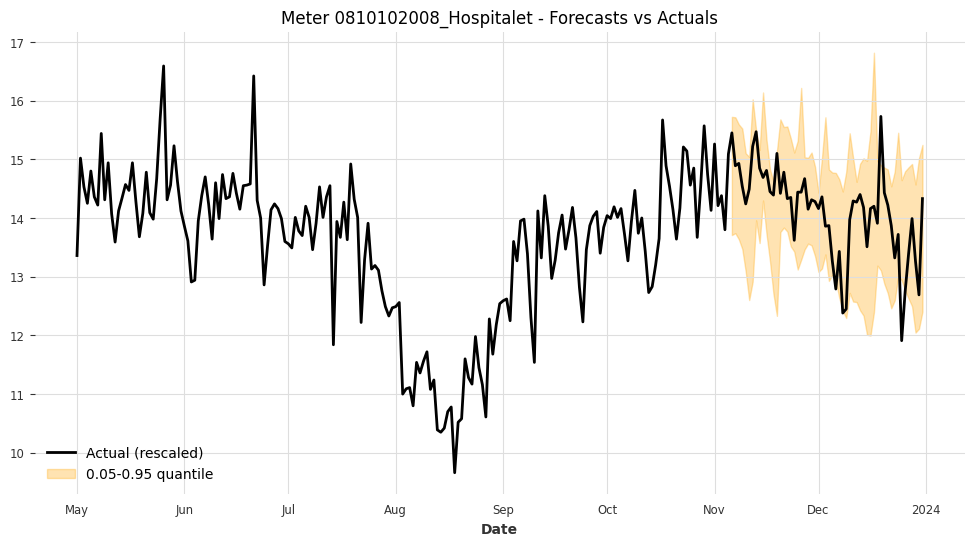

Meter 0810102008_Hospitalet - Coverage: 0.9107, Width: 2.1518



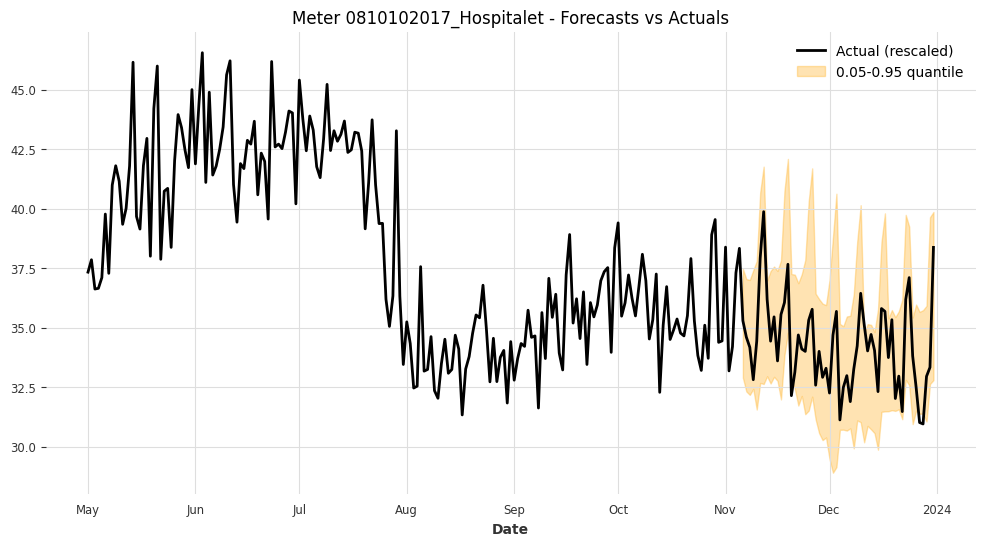

Meter 0810102017_Hospitalet - Coverage: 0.9286, Width: 5.8474



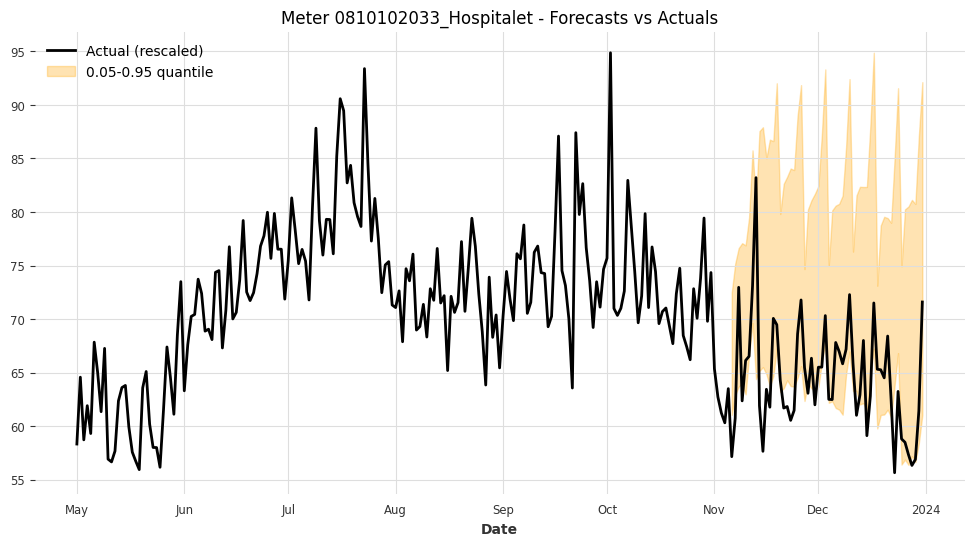

Meter 0810102033_Hospitalet - Coverage: 0.6071, Width: 19.7211



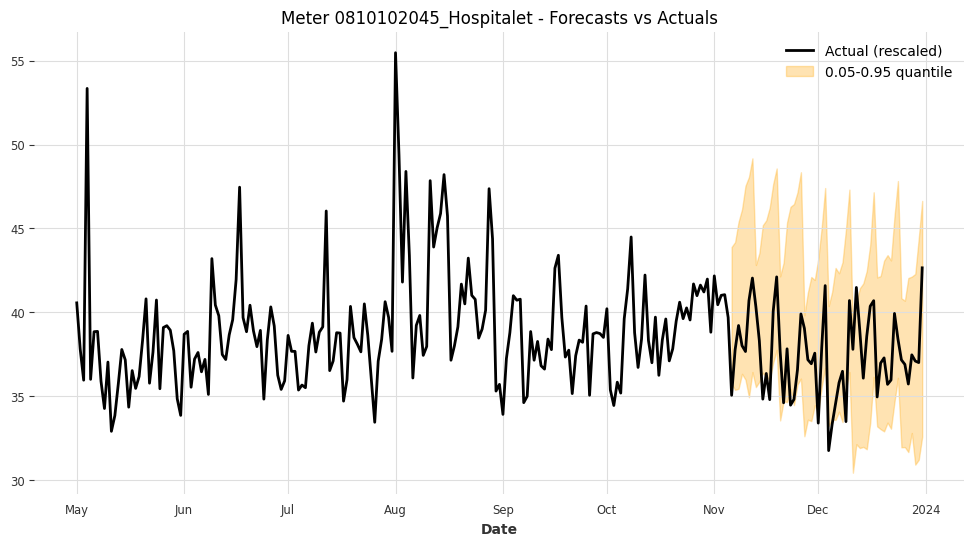

Meter 0810102045_Hospitalet - Coverage: 0.8214, Width: 9.8347



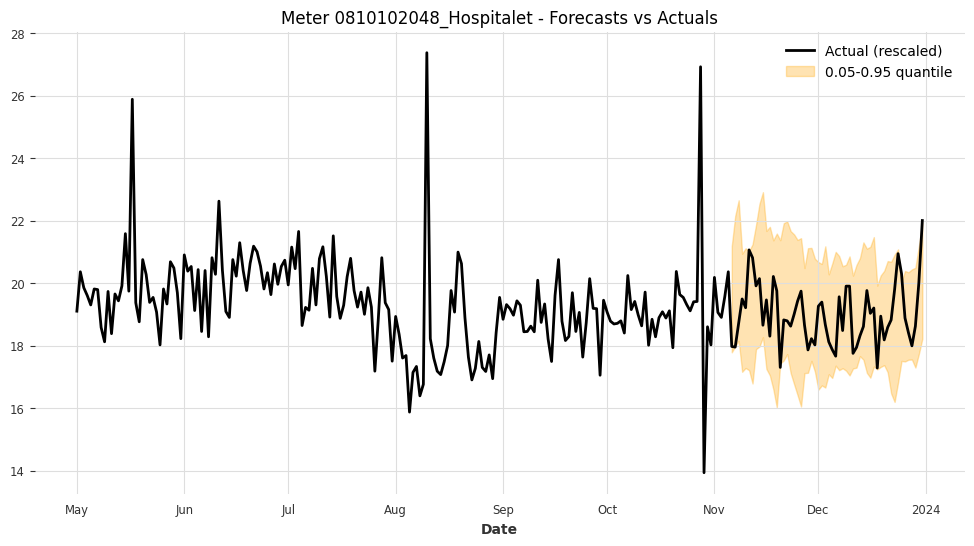

Meter 0810102048_Hospitalet - Coverage: 0.9107, Width: 3.8723



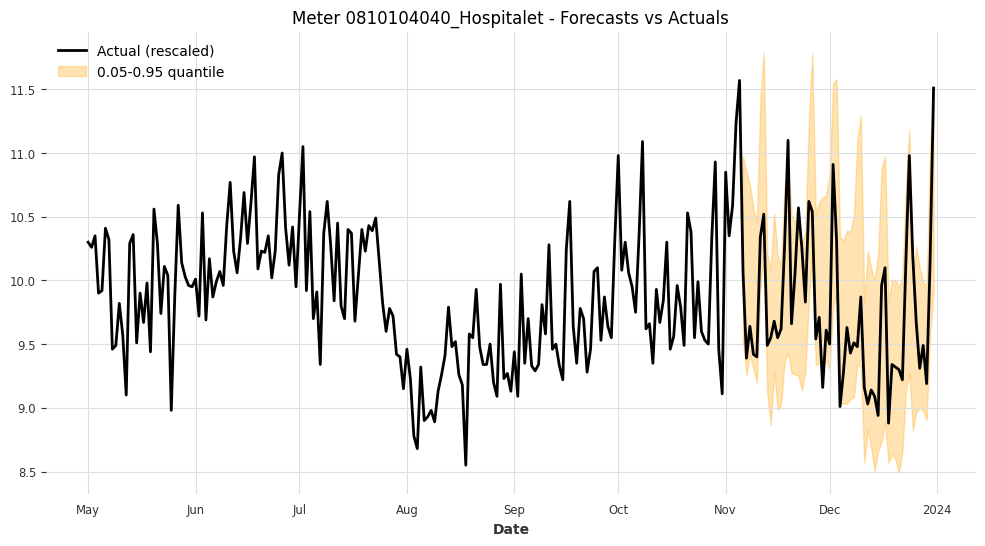

Meter 0810104040_Hospitalet - Coverage: 0.8929, Width: 1.3976



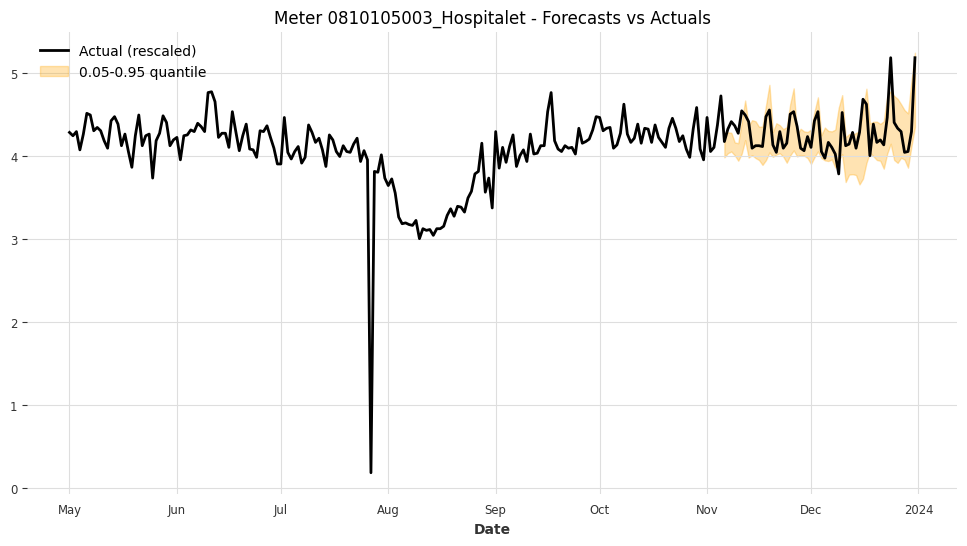

Meter 0810105003_Hospitalet - Coverage: 0.7857, Width: 0.4952



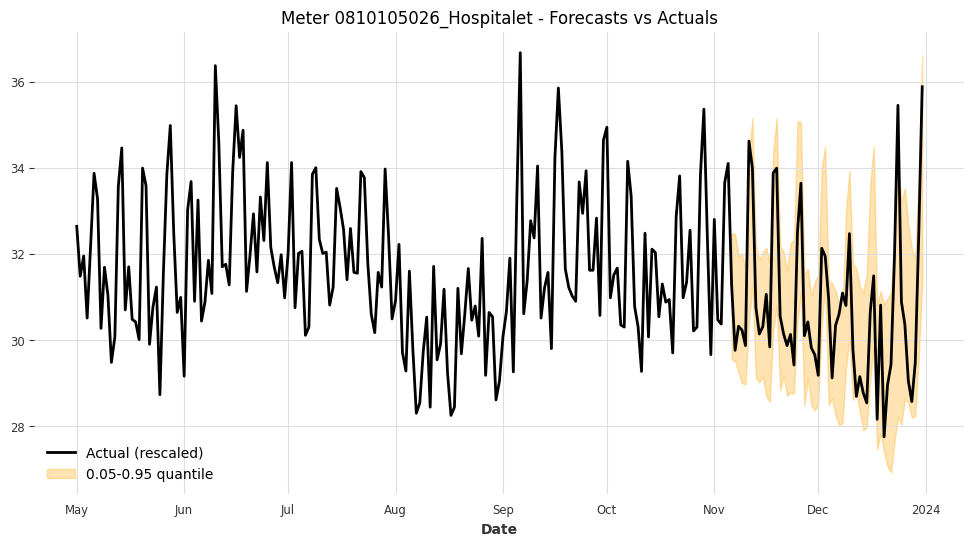

Meter 0810105026_Hospitalet - Coverage: 0.9286, Width: 3.5443



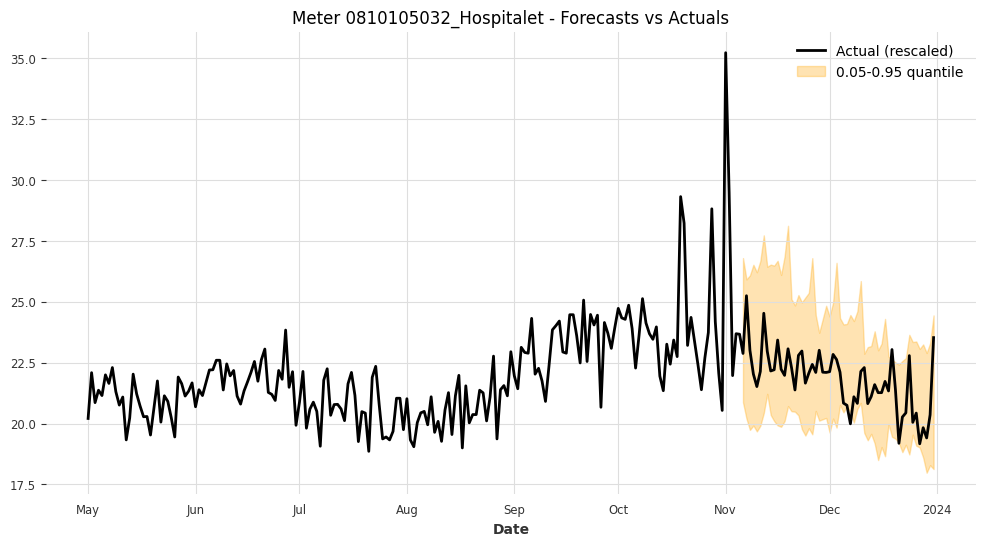

Meter 0810105032_Hospitalet - Coverage: 0.9464, Width: 4.9137



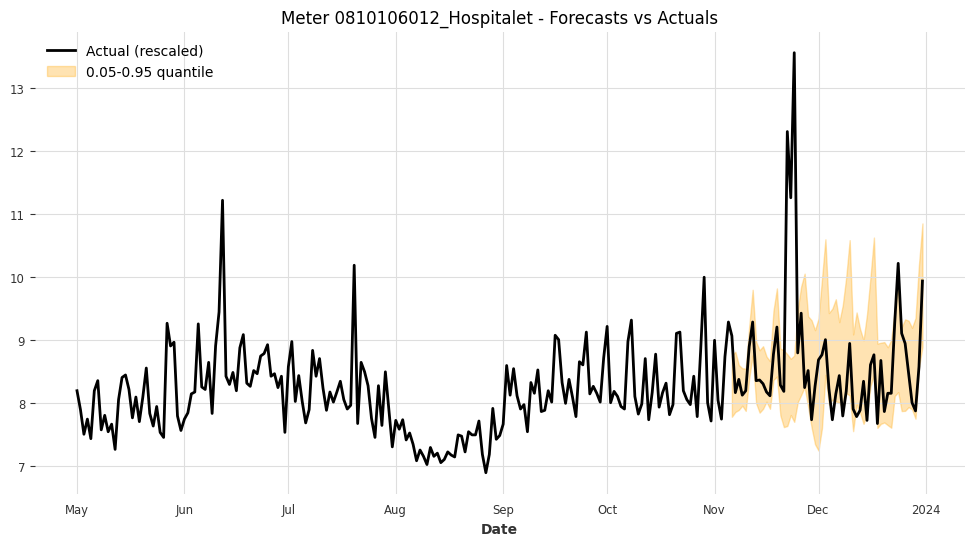

Meter 0810106012_Hospitalet - Coverage: 0.8214, Width: 1.3860



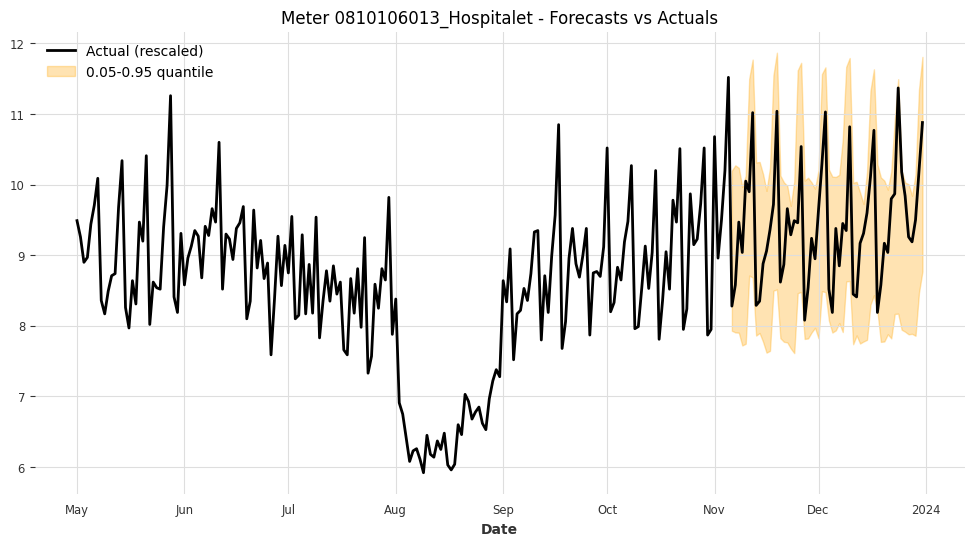

Meter 0810106013_Hospitalet - Coverage: 0.9821, Width: 2.4888



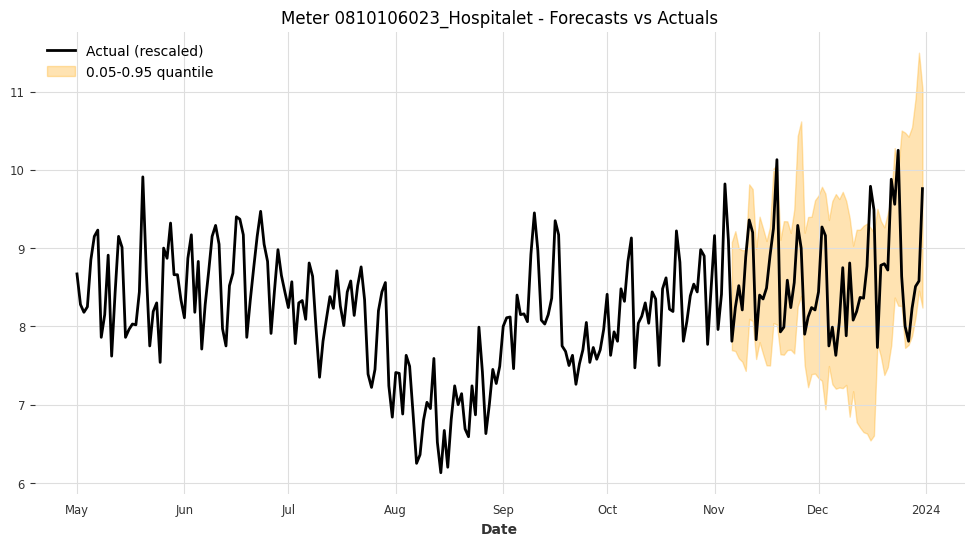

Meter 0810106023_Hospitalet - Coverage: 0.8929, Width: 2.0831



In [ ]:
import matplotlib.pyplot as plt
from darts import concatenate  # Darts utility to merge TimeSeries

for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")


In [ ]:
# Let's finish with the specifically selected test

In [ ]:
# Load model
model = RNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/rnnGRU/simple/rnnGRU_model.pkl")

In [ ]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/scaled_test_reduced.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [ ]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts in zip(meter_ids_test, test_series_scaled):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        historical_forecasts=hfcs,
        last_points_only=False,
        retrain=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 467.62it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801902043_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.251533        2.985701 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 401.63it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.151476        2.993156 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 464.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903021_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.458739        1.880828 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 444.31it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903026_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.273758        1.968321 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 465.56it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903035_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.821429  0.25447        0.712517 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 473.25it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.384794        2.262591 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 478.32it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801903213_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.250313        0.382978 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 476.65it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904027_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.322573        5.128904 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 470.69it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904047_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.267428        4.062225 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 465.83it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801904049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.535024        4.809863 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.91it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801905057_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  0.305013        3.364294 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 313.68it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801906071_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.892857  0.32208        1.703804 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 473.48it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0801910007_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.381166        1.246414 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 271.82it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0807302003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.165848        5.229198 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 467.70it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0807710008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.176235       73.313708 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 357.69it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101004_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.334987        7.711409 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 458.14it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101011_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.282134        4.229192 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 352.94it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101018_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.249405        1.256999 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 472.82it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101019_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.187662        1.324892 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 369.97it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101024_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  0.372349        3.205925 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 460.14it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101029_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.255597        6.315806 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 300.16it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.361626        5.536497 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 466.38it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101039_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9      0.75  0.261549        3.839543 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 456.98it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.392815        7.856294 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 454.85it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102005_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.287878        2.717569 



Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 451.47it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.607143  0.459406         6.44546 



Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from darts import concatenate  # Darts utility to merge TimeSeries

for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")
